In [1]:
# Imports
# General
import sys
sys.path.append('../')
import json

# drawing
import  matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix

# statistics
import numpy as np
import pandas as pd

# from watermark_eval.functions import evaluate_text_quality_ppl
import math
import os
import copy

import glob
import re
from multiprocessing import Pool

# NLP
import nltk
from nltk.translate.bleu_score import SmoothingFunction

# from rouge import Rouge
# from sacrebleu import sentence_bleu
from rouge_score import rouge_scorer
import evaluate

from transformers import AutoTokenizer
from tqdm import tqdm

/home/malghanim/anaconda3/envs/watermarking/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_parameters_vocab_based(filename):
    pattern = re.compile(r'_(?P<task>c4|lfqa)_.*?_(?P<language>Arabic|English|Chinese|Indonesian|Turkish|Hindi)_(?P<model>jais|sail|r7b)_(?P<method>kgw|unigram)_delta=(?P<delta>[0-9.]+)_gamma=(?P<gamma>[0-9.]+)', re.IGNORECASE)
    match = pattern.search(filename)
    if match:
        return match.group('task'), match.group('language'), match.group('model'), match.group('method'), float(match.group('delta')), float(match.group('gamma'))
    else:
        raise ValueError(f"Could not extract parameters from filename: {filename}")

def extract_parameters_semantic_based(filename):
    pattern = re.compile(r'_(?P<task>c4|lfqa)_.*?_(?P<language>Arabic|English|Chinese|Indonesian|Turkish|Hindi)_(?P<model>jais|sail|r7b)_(?P<method>xsir)_delta=(?P<delta>[0-9.]+)', re.IGNORECASE)
    match = pattern.search(filename)
    if match:
        return match.group('task'), match.group('language'), match.group('model'), match.group('method'), float(match.group('delta'))
    else:
        raise ValueError(f"Could not extract parameters from filename: {filename}")
def extract_parameters_sampling_based(filename):
    pattern = re.compile(r'_(?P<task>c4|lfqa)_.*?_(?P<language>Arabic|English|Chinese|Indonesian|Turkish|Hindi)_(?P<model>jais|sail|r7b)_(?P<method>exp)', re.IGNORECASE)
    match = pattern.search(filename)
    if match:
        return match.group('task'), match.group('language'), match.group('model'), match.group('method')
    else:
        raise ValueError(f"Could not extract parameters from filename: {filename}")
lang_dict_acronym = {"Arabic": "Ar", "English": "En", "Chinese": "Zh", "Indonesian": "Id"}

In [ ]:
languages = ['English', 'Arabic', 'Chinese', 'Indonesian', 'Turkish', 'Hindi']

experiment = 'quality' # 'quality' or 'attack'
all_methods = ['KGW', 'Unigram', 'XSIR', 'EXP']
file_dict = {}

for language in languages:
    file_dict[language] = {}
    for method in all_methods:
        file_path = f'../outputs/{experiment}/{method}/{language}/*.json'
        files = glob.glob(file_path)
        file_dict[language][method] = files


# Initialize an empty list to store the data
all_data = []


# Read each file and append its content to the list
for language in file_dict:
  for method in file_dict[language]:
    for file in file_dict[language][method]:
      with open(file, 'r') as f:
        data = json.load(f)
        if method == 'XSIR':
          task, lang, model, _, delta = extract_parameters_semantic_based(file)
          # if lang == "Hindi" or lang == "Turkish":
          #   continue
          if model != 'r7b':
            continue  # Skip some model types for XSIR method
          # if model == "qwen":
          #   continue
          # if model != 'sail':
          #   continue
          # if delta != 2.0:
          #   continue
          all_data.append({'task': task, 'language': lang, 'model': model, 'method': method, 'delta': delta, 'data': data})
        elif method == 'EXP':
          task, lang, model, _ = extract_parameters_sampling_based(file)
          # if lang == "Hindi" or lang == "Turkish":
          #   continue
          if model != 'r7b':
            continue
          # if model == "qwen":
          #   continue
          # if model != 'sail':
          #   continue
          all_data.append({'task': task, 'language': lang, 'model': model, 'method': method, 'data': data})
        else:
          task, lang, model, _, delta, gamma = extract_parameters_vocab_based(file)
          # if lang == "Hindi" or lang == "Turkish":
          #   continue
          # if gamma != 0.5:
          #   continue
          # if delta != 2.0:
          #   continue
          # # print(f"src: {src}, tgt: {tgt}, pipeline: {pipeline}, delta: {delta}, gamma: {gamma}")
          if model != 'r7b':
            continue
          # if model == "qwen":
          #   continue
          # if model != 'sail':
          #   continue
          all_data.append({'task': task, 'language': lang, 'model': model, 'method': method, 'delta': delta, 'gamma': gamma, 'data': data})
    

In [4]:
print(len(all_data))
print(len(file_dict))

50
6


In [ ]:
deltas = [2.0, 5.0, 10.0]
gammas = [0.1, 0.5, 0.9]

In [6]:
# initialize dictionaries for KGW data

kgw_unigram_data = {
    'gamma': gammas*len(deltas), # 5 is the length of the other parameter (delta here)
    'delta': [delta for delta in deltas for _ in range(len(gammas))], # 4 is the length of the other parameter (gamma here)
    'z_scores': [None]*len(deltas)*len(gammas),
    'perplexity': [None]*len(deltas)*len(gammas),
    'gpt_judge': [None]*len(deltas)*len(gammas),
    'final_verdict': [None]*len(deltas)*len(gammas),
    'examples': [None]*len(deltas)*len(gammas),
}

exp_data = {
    'pvals': [None],
    'perplexity': [None],
    'gpt_judge': [None],
    'final_verdict': [None],
    'examples': [None],
}

semantic_data = {
    'delta': deltas,
    'z_scores': [None]*len(deltas),
    'perplexity': [None]*len(deltas),
    'gpt_judge': [None]*len(deltas),
    'final_verdict': [None]*len(deltas),
    'examples': [None]*len(deltas),
}


kgw_unigram_df = pd.DataFrame(kgw_unigram_data)
exp_df = pd.DataFrame(exp_data)
semantic_df = pd.DataFrame(semantic_data)

# create a dictionary to store the dataframes
df_dict = {
    'KGW': {
        'English': copy.deepcopy(kgw_unigram_df),
        'Arabic': copy.deepcopy(kgw_unigram_df),
        'Chinese': copy.deepcopy(kgw_unigram_df),
        'Indonesian': copy.deepcopy(kgw_unigram_df),
        'Turkish': copy.deepcopy(kgw_unigram_df),
        'Hindi': copy.deepcopy(kgw_unigram_df),
    },
    'Unigram': {
        'English': copy.deepcopy(kgw_unigram_df),
        'Arabic': copy.deepcopy(kgw_unigram_df),
        'Chinese': copy.deepcopy(kgw_unigram_df),
        'Indonesian': copy.deepcopy(kgw_unigram_df),
        'Turkish': copy.deepcopy(kgw_unigram_df),
        'Hindi': copy.deepcopy(kgw_unigram_df),
    },
    'EXP': {
        'English': copy.deepcopy(exp_df),
        'Arabic': copy.deepcopy(exp_df),
        'Chinese': copy.deepcopy(exp_df),
        'Indonesian': copy.deepcopy(exp_df),
        'Turkish': copy.deepcopy(exp_df),
        'Hindi': copy.deepcopy(exp_df),
    },
    'XSIR': {
        'English': copy.deepcopy(semantic_df),
        'Arabic': copy.deepcopy(semantic_df),
        'Chinese': copy.deepcopy(semantic_df),
        'Indonesian': copy.deepcopy(semantic_df),
        'Turkish': copy.deepcopy(semantic_df),
        'Hindi': copy.deepcopy(semantic_df),
    }
}

# add another level for the task
df_dict = {
    'c4': copy.deepcopy(df_dict),
    'lfqa': copy.deepcopy(df_dict),
}

In [ ]:
df_dict['c4']['KGW']['Hindi'], df_dict['lfqa']['Unigram']['English'], df_dict['c4']['Unigram']['Turkish'], df_dict['lfqa']['KGW']['Arabic'], df_dict['c4']['Unigram']['English'], df_dict['lfqa']['Unigram']['English'], df_dict['c4']['Unigram']['Arabic'], df_dict['lfqa']['Unigram']['Arabic'], df_dict['c4']['EXP']['English'], df_dict['lfqa']['EXP']['English'], df_dict['c4']['EXP']['Arabic'], df_dict['lfqa']['EXP']['Arabic'], df_dict['c4']['XSIR']['English'], df_dict['lfqa']['XSIR']['English'], df_dict['c4']['XSIR']['Arabic'], df_dict['lfqa']['XSIR']['Arabic']

In [ ]:
z_scores = []
ppls = []
gpt_judge = []
final_verdict = []
examples = []


for data in all_data:
    z_scores_col_name = 'z_scores'
    language = data['language']
    method = data['method']
    inner_data = data['data']
    task = data['task']
    if method == 'EXP':
        z_scores_col_name = 'pvals'
    if method == 'XSIR':
        if data['delta'] == 1.0:
            continue
    for idx, elements in enumerate(inner_data[:500]):
        z_scores.append(elements[z_scores_col_name])
        # temp fix for the missing perplexity in some files
        ppls.append(elements.get('ppl', [0, 0, 0]))
        examples.append([elements['prompt'], elements['natural_text'], elements['unwatermarked_sample'], elements['watermarked_sample']])
        gpt_judge.append(elements['singhZouGptJudge'])
        # print(f"index {idx}", method, language, task, elements['singhZouGptJudge'])
        final_verdict.append(elements['final_verdict'])
    df = df_dict[task][method][language]
    if method == 'XSIR':
        index = df[df['delta'] == data['delta']].index[0]
    elif method in ['KGW', 'Unigram']:
        index = df[(df['gamma'] == data['gamma']) & (df['delta'] == data['delta'])].index[0]
    else:
        index = 0
    df.at[index, z_scores_col_name] = z_scores
    df.at[index, 'perplexity'] = ppls
    df.at[index, 'gpt_judge'] = gpt_judge
    df.at[index, 'final_verdict'] = final_verdict
    df.at[index, 'examples'] = [example[1:] for example in examples]

    z_scores = []
    ppls = []
    examples = []
    gpt_judge = []
    final_verdict = []


In [10]:
df_dict['c4']['Unigram']['Turkish']['gpt_judge']

0                                                 None
1    [[[1, 1, 1, 1, 1, 1, 1], [3, 3, 3, 3, 3, 3, 3]...
2                                                 None
3                                                 None
4                                                 None
5                                                 None
6                                                 None
7                                                 None
8                                                 None
Name: gpt_judge, dtype: object

In [10]:
def kgw_family_perplexity_plots(language='Arabic', task='c4'):
    for method in ['KGW', 'Unigram']:
        df = df_dict[task][method][language]
        # Set up the plot
        save_path = f'figures/{method}/{language}/ppl_distr_{language}_{method}.pdf'
        fig, axes = plt.subplots(nrows=len(gammas), ncols=len(deltas), figsize=(25, 15), sharey=True)

        # Create boxplots for each combination of gamma and delta
        for i, (gamma, delta) in enumerate([(g, d) for g in gammas for d in deltas]):
            ax = axes[i // len(deltas), i % len(deltas)]
            data_subset = copy.deepcopy(df[(df['gamma'] == gamma) & (df['delta'] == delta)]['perplexity'])
            
            # Extract perplexity values
            unwatermarked_perplexity = []
            watermarked_perplexity = []

            for perplexity_lists in data_subset:
                for perp_list in perplexity_lists:
                    # Only for Arabic to penalize the higher perplexity values
                    unwm, wm = math.log(perp_list[0]), math.log(perp_list[1])
                    unwatermarked_perplexity.append(unwm)
                    watermarked_perplexity.append(wm)
            perplexity_values = [unwatermarked_perplexity, watermarked_perplexity]
            ax.boxplot(perplexity_values)
            if i >= 6:
                ax.set_xticklabels(['Unwatermarked', 'Watermarked'], fontsize=32, rotation=15)
            else:
                ax.set_xticklabels([])
            if i == 0 or i == 1 or i == 2:
                ax.set_title(f'Delta:{delta}', fontsize=32)

            ax.tick_params(axis='both', which='major', labelsize=32)
        # set subtitles for each row
        for i, gamma in enumerate(gammas):
            axes[i, 0].set_ylabel(f'log(PPL) γ:{gamma}', fontsize=32)
        plt.tight_layout()
        # plt.savefig(save_path, format='pdf')
        plt.show()

In [ ]:
# XSIR
def xsir_perplexity_plots(task='c4'):
    fig, axes = plt.subplots(nrows=4, ncols=len(deltas), figsize=(25, 15), sharey=True)
    # fig.suptitle('Distribution of Log Perplexity Values for Texts', fontsize=16)
    save_path = f'figures/XSIR/ppl_distr_xsir_all_langs.pdf'
    method = 'XSIR'

    for i, language in enumerate(df_dict[task][method]):
        df = df_dict[task][method][language]
        for j, delta in enumerate(deltas):
            ax = axes[i][j]
            data_subset = copy.deepcopy(df[df['delta'] == delta]['perplexity'])
            unwatermarked_perplexity = []
            watermarked_perplexity = []
            for perplexity_lists in data_subset:
                for perp_list in perplexity_lists:
                    unwm, wm = math.log(perp_list[0]), math.log(perp_list[1])
                    unwatermarked_perplexity.append(unwm)
                    watermarked_perplexity.append(wm)
            perplexity_values = [unwatermarked_perplexity, watermarked_perplexity]
            ax.boxplot(perplexity_values)
            ax.set_title(f'{language} Delta: {delta}', fontsize=32)
            ax.tick_params(axis='both', labelsize=32)
            if i >= 3:
                ax.set_xticklabels(['Unwatermarked', 'Watermarked'], fontsize=32, rotation=15)
            else:
                ax.set_xticklabels([])
            # ax.set_title(f'{language} Delta: {delta}')
            # if i == 3:
            #     ax.set_xlabel('Text Type')
            if j == 0 or j == 3 or j == 6 or j == 9:
                ax.set_ylabel('log(PPL)', fontsize=32)
    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

In [ ]:
# EXP
def exp_perplexity_plots(task='c4'):
    # Set up the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(19, 15), sharey=True)
    save_path = f'figures/EXP/ppl_distr_exp_all_langs.pdf'
    # Create boxplots for each language
    method = 'EXP'
    for i, language in enumerate(languages):
        ax = axes[i//2, i%2]
        df = df_dict[task][method][language]
        data_subset = copy.deepcopy(df['perplexity'])
        # Extract perplexity values
        unwatermarked_perplexity = []
        watermarked_perplexity = []

        for perplexity_lists in data_subset:
            for perp_list in perplexity_lists:
                unwm, wm = math.log(perp_list[0]), math.log(perp_list[1])
                unwatermarked_perplexity.append(unwm)
                watermarked_perplexity.append(wm)
        perplexity_values = [unwatermarked_perplexity, watermarked_perplexity]
        ax.boxplot(perplexity_values)
        ax.set_title(f'{language}', fontsize=32)
        
        ax.tick_params(axis='both', labelsize=32)
        if i == 0 or i == 2:
            ax.set_ylabel('log(PPL)', fontsize=32)
        if i == 2 or i == 3:
            ax.set_xticklabels(['Unwatermarked', 'Watermarked'], fontsize=32, rotation=15)
        else:
            ax.set_xticklabels([])

    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

In [ ]:
for language in languages:
    kgw_family_perplexity_plots(language)

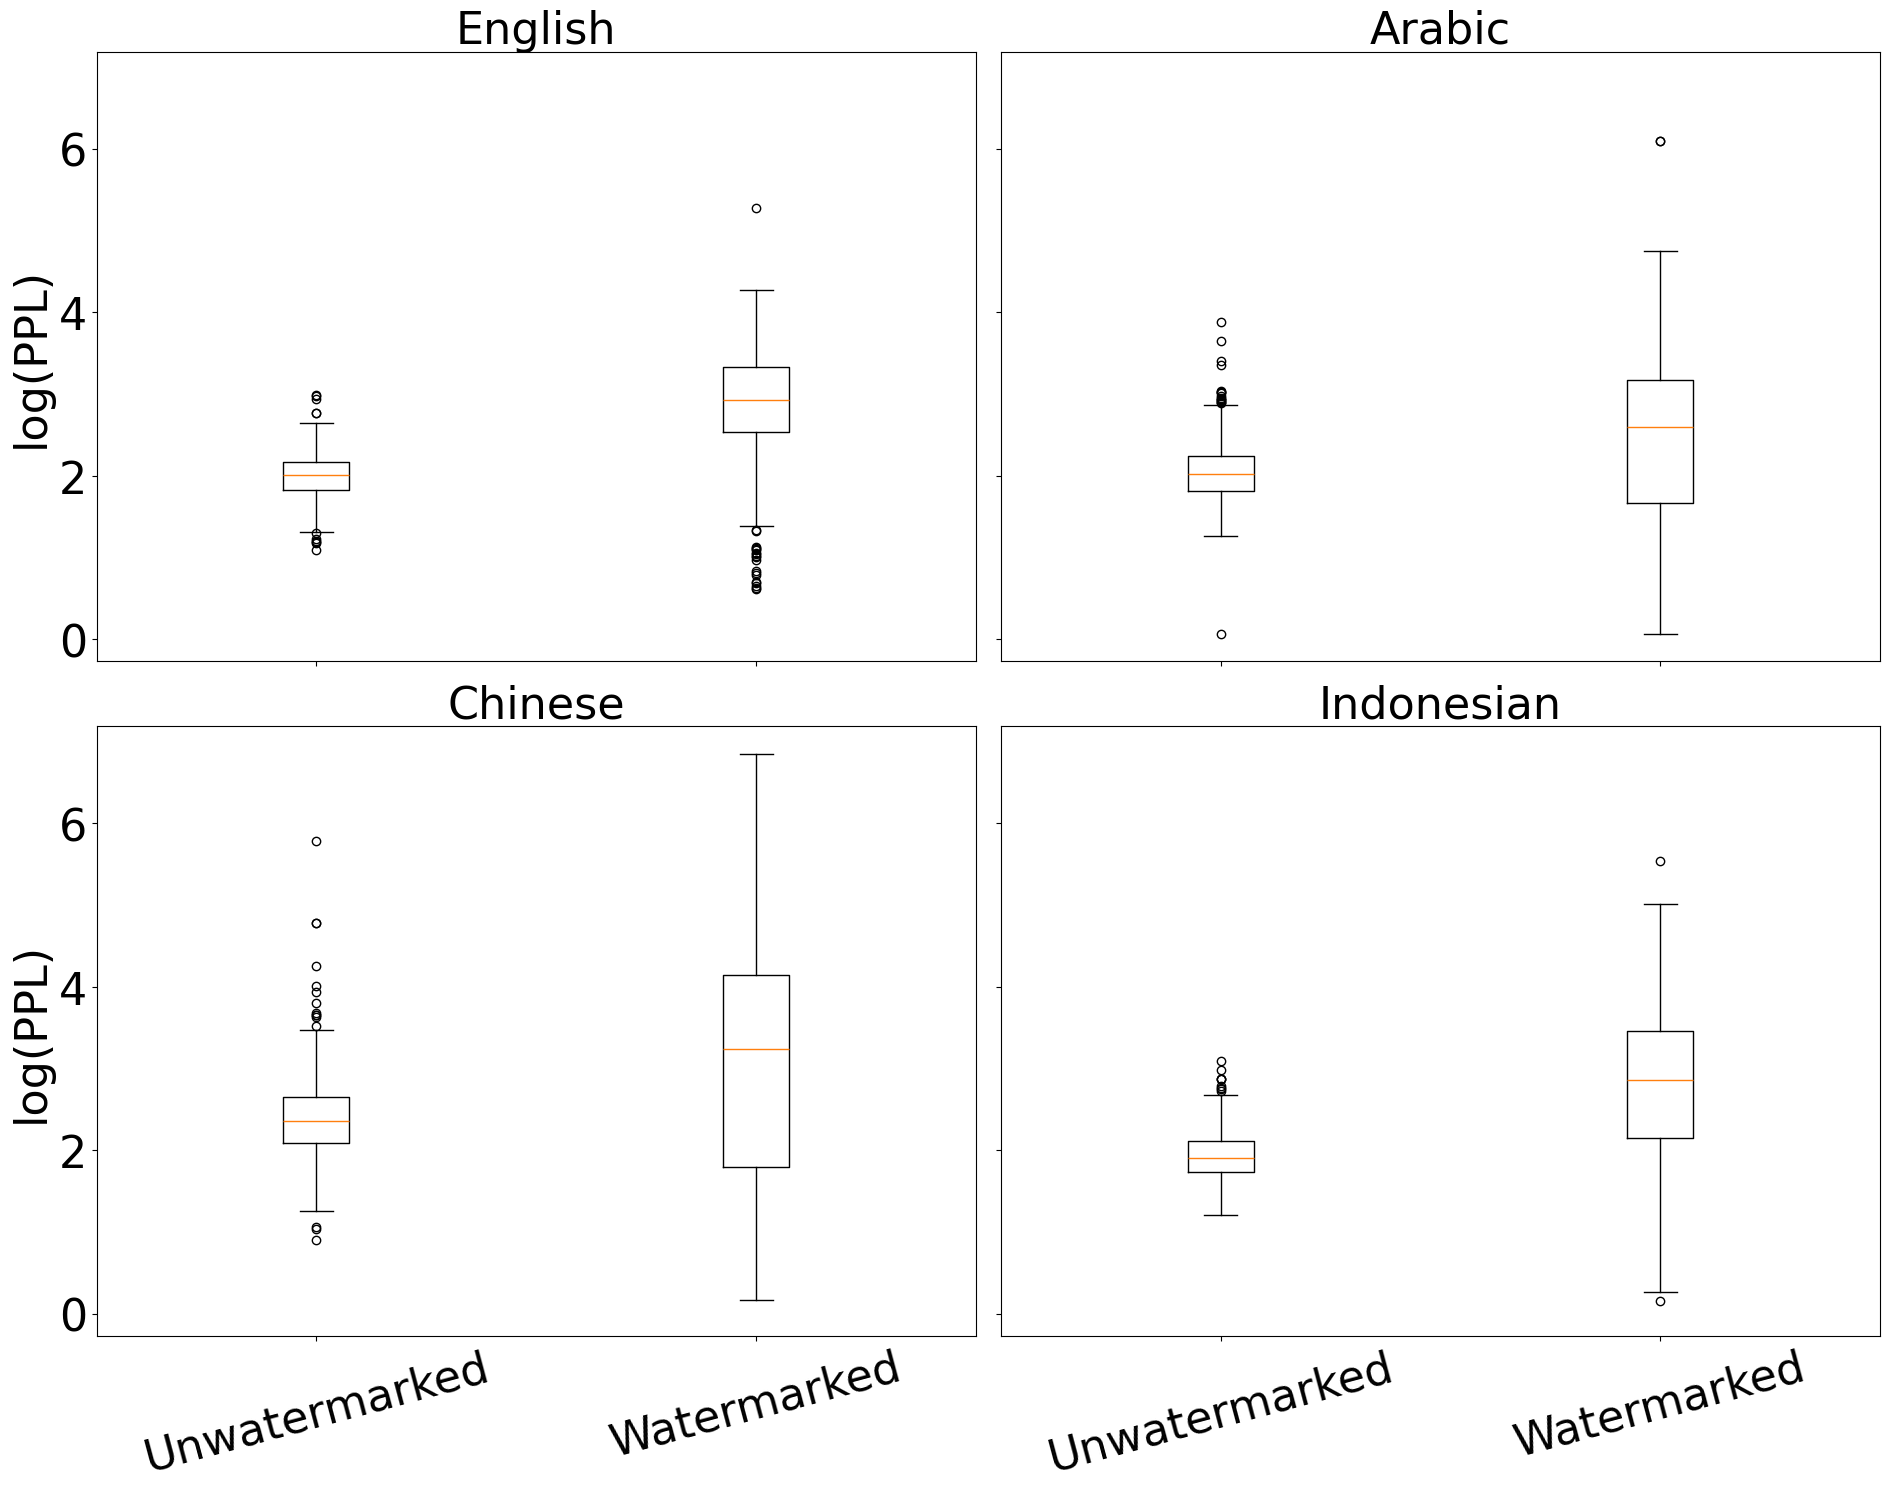

In [17]:
exp_perplexity_plots()

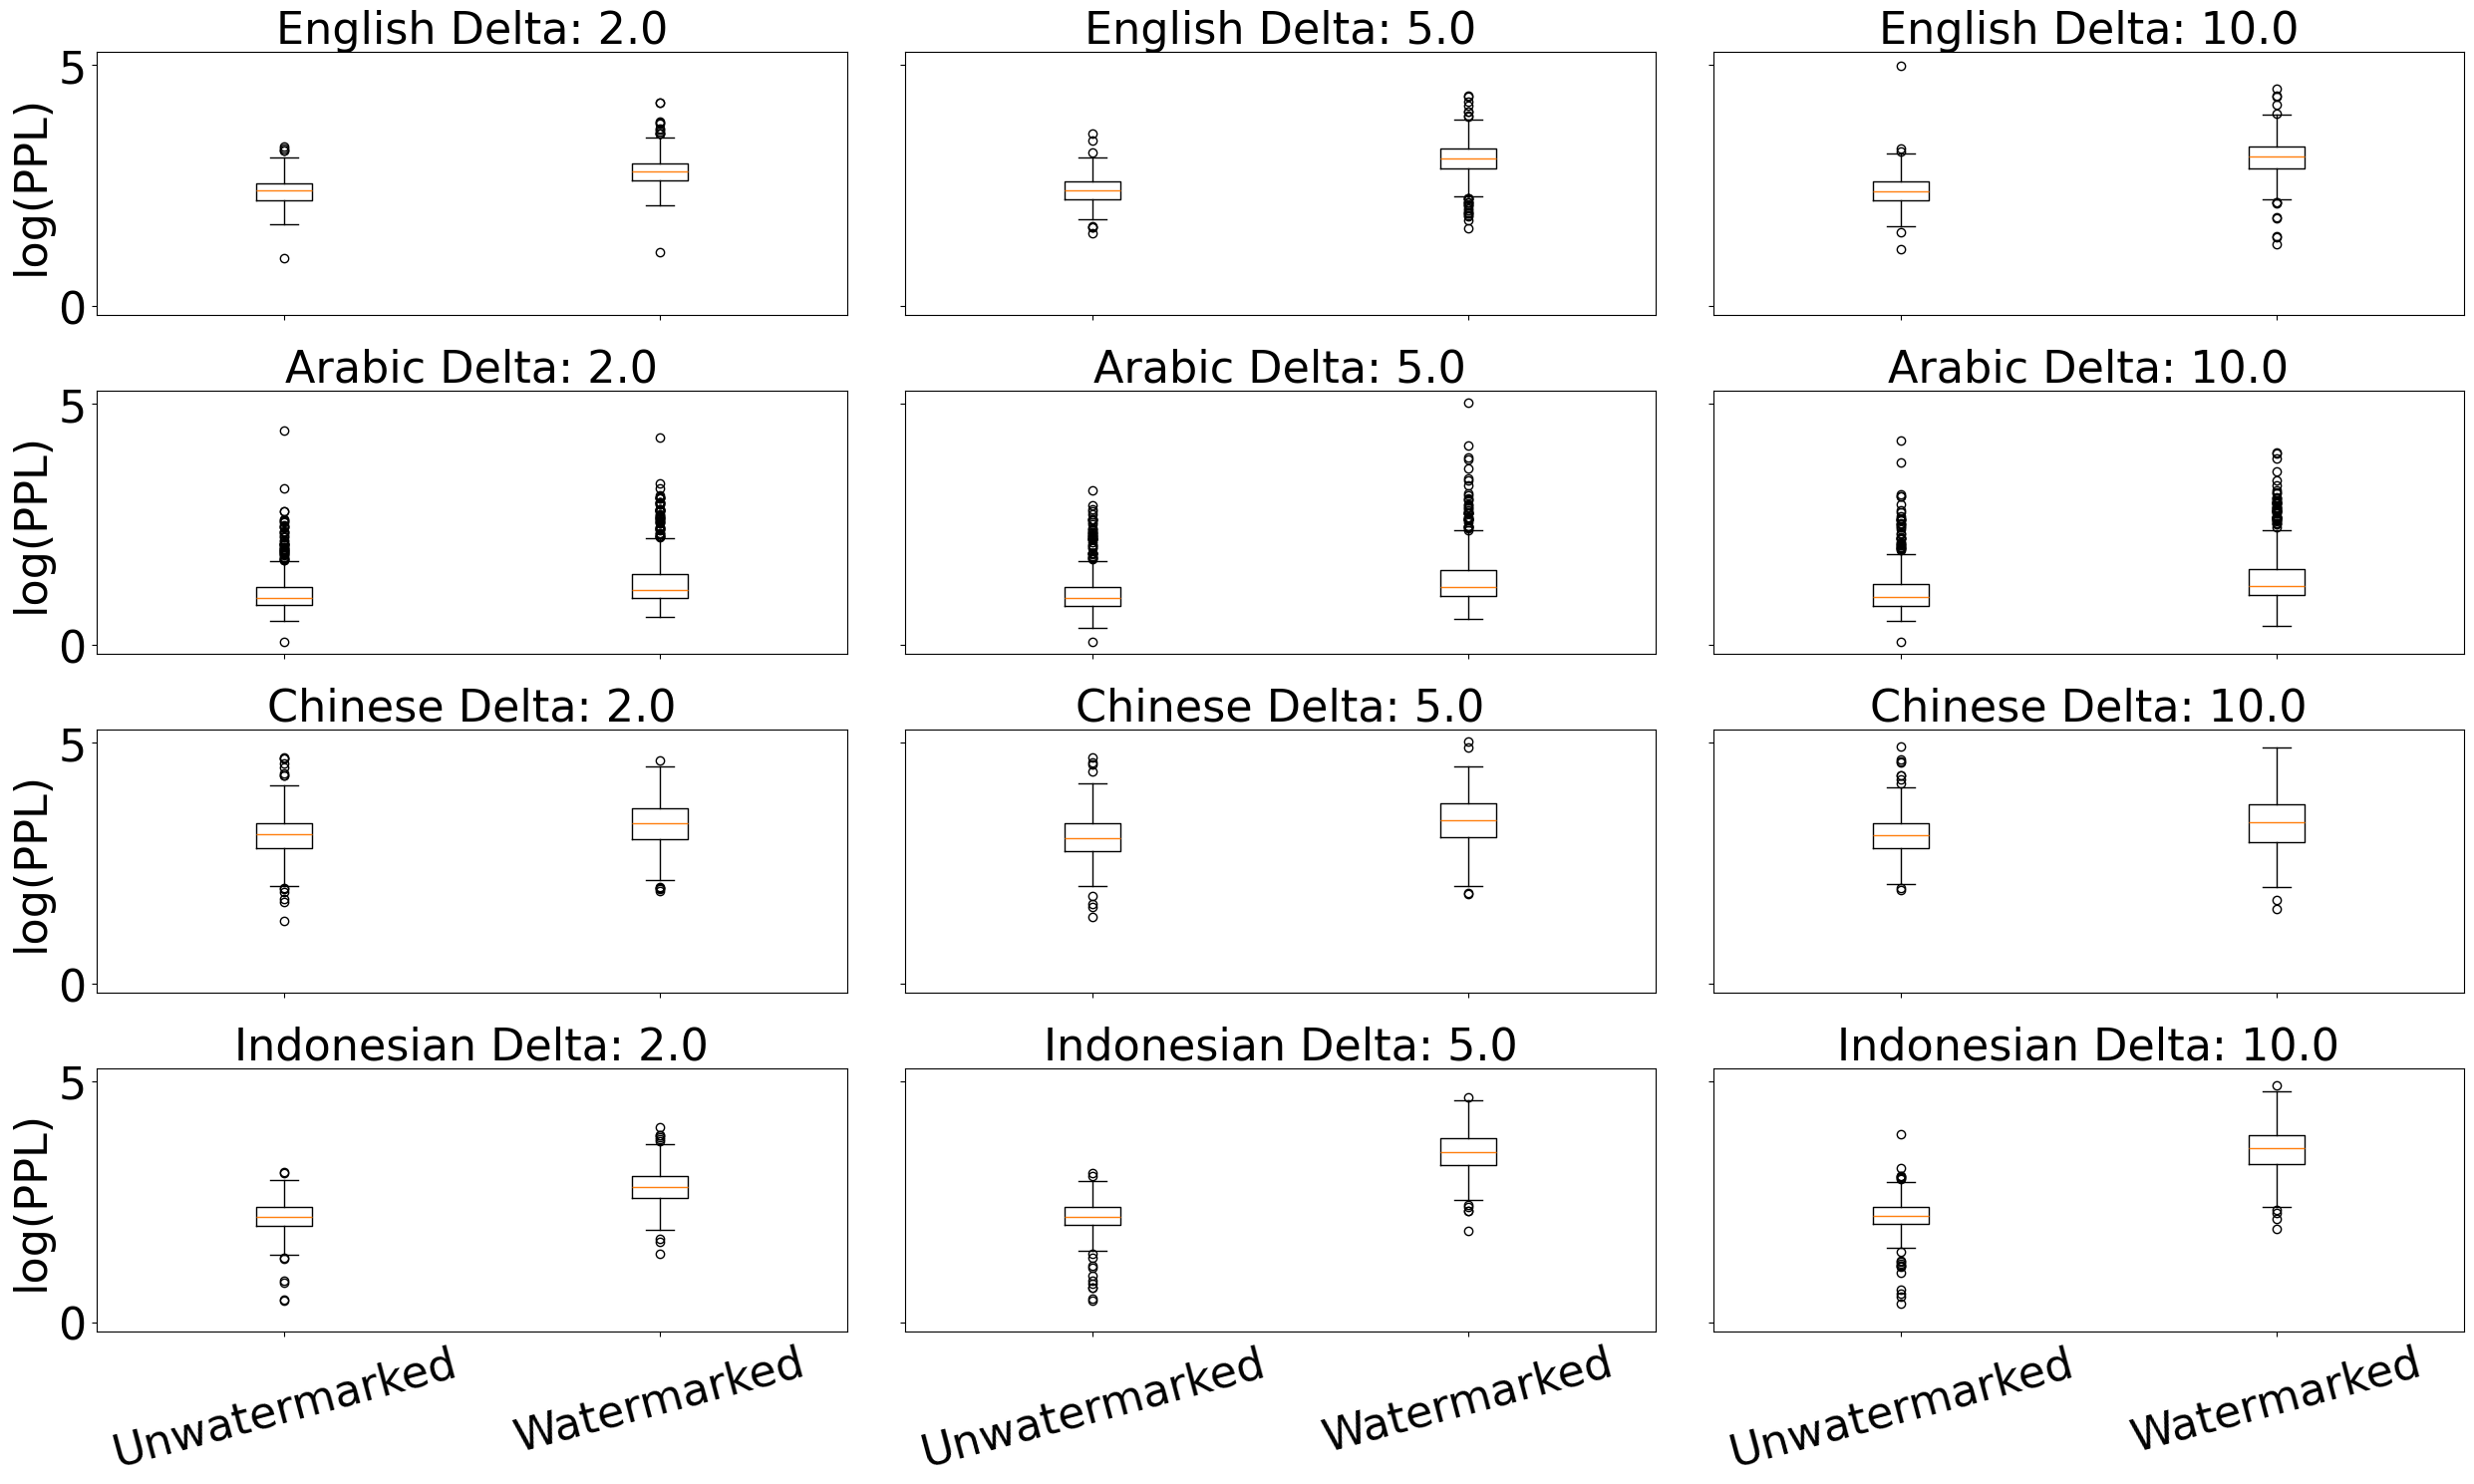

In [20]:
xsir_perplexity_plots()

In [ ]:
# relate z_scores and perplexities for only watermarked text for Unigram and kgw
def kgw_family_relate_z_scores_ppls(task = 'c4', method = 'KGW', language='Arabic', ppl_type='watermarked'):
    df = df_dict[task][method][language]
    save_path = f'figures/{method}/{language}/z_scores_ppl_{language}_{method}_{ppl_type}.pdf'
    # Average z_scores and perplexities
    if ppl_type == 'watermarked':
        index = 2
        avg_z_scores_col_name = "wm_avg_z_scores"
        avg_ppl_col_name = "wm_avg_perplexity"
    elif ppl_type == 'unwatermarked':
        index = 1
        avg_z_scores_col_name = "unwm_avg_z_scores"
        avg_ppl_col_name = "unwm_avg_perplexity"

    df[avg_z_scores_col_name] = df['z_scores'].apply(lambda x: np.mean([item[index] for item in x]))
    df[avg_ppl_col_name] = df['perplexity'].apply(lambda x: math.log(np.mean([item[index-1] for item in x])))

    # Plot
    fig, ax = plt.subplots(figsize=(4, 3))
    gamma_norm = mcolors.Normalize(vmin=0.1, vmax=0.9)
    cmap = cm.winter_r
    
    scatter = ax.scatter(df[avg_ppl_col_name], df[avg_z_scores_col_name],
                        c=df['gamma'], norm=gamma_norm, cmap=cmap, s=50,
                        alpha=0.8, edgecolors='w',
                        marker='none')

    # Adding delta markers
    markers = ['o', 'x', 's']
    handles = []
    for i, delta in enumerate(sorted(df['delta'].unique())):
        subset = df[df['delta'] == delta]
        pts = ax.scatter(subset[avg_ppl_col_name], subset[avg_z_scores_col_name],
                        c=subset['gamma'], norm=gamma_norm, cmap=cmap, s=50,
                        alpha=0.8, edgecolors='w', marker=markers[i])

    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel('log(PPL) (better →)', fontsize=10)
    ax.set_ylabel('z_score (better →)', fontsize=10)

    ax.invert_xaxis()

    # Threshold line at z_score = 4
    ax.axhline(y=4, color='red', linestyle='--')

    # Create a custom legend with gray markers
    custom_handles = [
    plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markeredgecolor='gray', markersize=5, label=f'δ = {delta}')
    for m, delta in zip(markers, sorted(df['delta'].unique()))
    ]
    ax.legend(handles=custom_handles, bbox_to_anchor=(0.5, 1.2), ncols=3, loc='upper center', fontsize=9, reverse=True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('γ', rotation=0)

    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

# Trying to put all figures in one plot
# relate z_scores and perplexities for only watermarked text
def kgw_family_relate_z_scores_ppls_all(task = 'c4', method = 'KGW', ppl_type='watermarked'):
    # Average z_scores and perplexities
    if ppl_type == 'watermarked':
        index = 2
        avg_z_scores_col_name = "wm_avg_z_scores"
        avg_ppl_col_name = "wm_avg_perplexity"
    elif ppl_type == 'unwatermarked':
        index = 1
        avg_z_scores_col_name = "unwm_avg_z_scores"
        avg_ppl_col_name = "unwm_avg_perplexity"

    languages = ["English", "Arabic", "Chinese", "Indonesian"]


    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.5, 4))
    gamma_norm = mcolors.Normalize(vmin=0.1, vmax=0.9)
    cmap = cm.winter_r # last was winter_r
    

    # Adding delta markers
    markers = ['o', 'x', 's']
    handles = []
    dataframes = [df_dict[task][method]['English'], df_dict[task][method]['Arabic'], df_dict[task][method]['Chinese'], df_dict[task][method]['Indonesian']]
    for idx, (language, df) in enumerate(zip(languages, dataframes)):
        df[avg_z_scores_col_name] = df['z_scores'].apply(lambda x: np.mean([item[index] for item in x]))
        df[avg_ppl_col_name] = df['perplexity'].apply(lambda x: math.log(np.mean([item[index-1] for item in x])))
        ax = axes[idx // 2, idx % 2]
        scatter = ax.scatter(df[avg_ppl_col_name], df[avg_z_scores_col_name],
                            c=df['gamma'], norm=gamma_norm, cmap=cmap, s=40,
                            alpha=0.8,
                            marker='none')

        ims = []
        for i, delta in enumerate(sorted(df['delta'].unique())):
            
            subset = df[df['delta'] == delta]
            pts = ax.scatter(subset[avg_ppl_col_name], subset[avg_z_scores_col_name],
                            c=subset['gamma'], norm=gamma_norm, cmap=cmap, s=40,
                            alpha=0.8, marker=markers[i])
            ims.append(pts)

        # set xlabel only for the second row and ylable only for the first column
        if idx == 2 or idx == 3:
            ax.set_xlabel('log(PPL) (better →)', fontsize=9)
        if idx == 0 or idx == 2:
            ax.set_ylabel('z_score (better →)', fontsize=9)

        ax.set_title(f'{language}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.invert_xaxis()

        # Threshold line at z_score = 4
        ax.axhline(y=4, color='red', linestyle='--')

        # Create a custom legend with gray markers
        custom_handles = [
        plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markeredgecolor='gray', markersize=5, label=f'δ = {delta}')
        for m, delta in zip(markers, sorted(df['delta'].unique()))
        ]
        ax.grid(True)

    axes[0,1].legend(handles=custom_handles, loc='upper right', reverse=True, fontsize=9)
    plt.tight_layout()
    
    cbar = fig.colorbar(ims[-1], ax=axes.ravel().tolist(), shrink=0.7)
    cbar.set_label('γ', rotation=0)
    # make the colorbar tick labels bigger
    cbar.ax.tick_params(labelsize=9)
    # plt.tight_layout(rect=[0, 0, 0.78, 1])
    save_path = f'figures/{method}/z_scores_ppl_all_{method}_{ppl_type}_small.pdf'
    # plt.savefig(save_path, format='pdf')
    plt.show()

/tmp/ipykernel_72383/3584932848.py:23: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('none').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(df[avg_ppl_col_name], df[avg_z_scores_col_name],
/tmp/ipykernel_72383/3584932848.py:33: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pts = ax.scatter(subset[avg_ppl_col_name], subset[avg_z_scores_col_name],


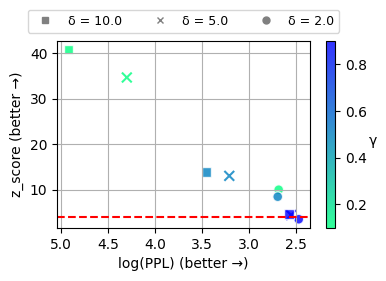

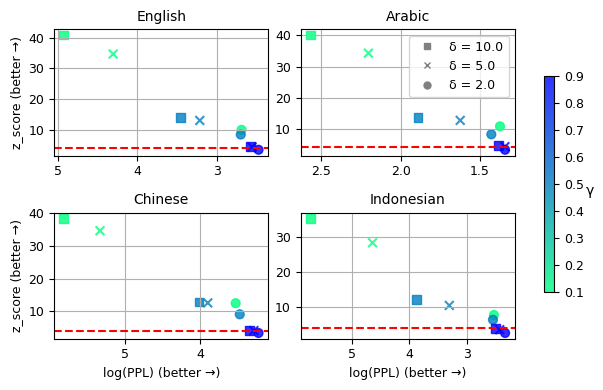

In [22]:
# Relatioonship between z_scores and perplexities for Arabic
kgw_family_relate_z_scores_ppls('KGW', 'English', ppl_type='watermarked')

# or all together
kgw_family_relate_z_scores_ppls_all('KGW', ppl_type='watermarked')

In [ ]:


# XSIR
def xsir_z_score_perplexity_scatter(task='c4', ppl_type='watermarked'):
    if ppl_type == 'watermarked':
        index = 2
        avg_z_scores_col_name = "wm_avg_z_scores"
        avg_ppl_col_name = "wm_avg_perplexity"
    elif ppl_type == 'unwatermarked':
        index = 1
        avg_z_scores_col_name = "unwm_avg_z_scores"
        avg_ppl_col_name = "unwm_avg_perplexity"

    save_path = f'figures/XSIR/z_score_ppl_scatter_xsir_mean_smaller.pdf'
    fig, axes = plt.subplots(2, 2, figsize=(6.5, 4))
    cmap = cm.winter_r
    norm = plt.Normalize(vmin=0.1, vmax=0.9)  # Example color range
    markers = ['x', '*', 's']
    handles = []
    method = 'XSIR'
    dfs = df_dict[task][method]
    for idx, (lang, df) in enumerate(dfs.items()):
        df[avg_z_scores_col_name] = df['z_scores'].apply(lambda x: np.mean([item[index] for item in x]))
        df[avg_ppl_col_name] = df['perplexity'].apply(lambda x: math.log(np.mean([item[index-1] for item in x])))
        ax = axes[idx // 2, idx % 2]
        scatter = ax.scatter(df[avg_ppl_col_name], df[avg_z_scores_col_name],
                            c=[0.5]*len(df[avg_ppl_col_name]), norm=norm, cmap=cmap, s=40,
                            alpha=0.8,
                            marker='none')
        ims = []
        for i, delta in enumerate(sorted(df['delta'].unique())):
            subset = df[df['delta'] == delta]
            pts = ax.scatter(subset[avg_ppl_col_name], subset[avg_z_scores_col_name],
                            c=[0.5]*len(subset), norm=norm,
                            cmap=cmap, s=40,
                            alpha=0.8, marker=markers[i])
            ims.append(pts)
        if idx == 2 or idx == 3:
            ax.set_xlabel('log(PPL) (better →)', fontsize=9)
        if idx == 0 or idx == 2:
            ax.set_ylabel('z_score (better →)', fontsize=9)

        ax.set_title(f'{lang}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.invert_xaxis()

        # Threshold line at z_score = 4
        ax.axhline(y=0.2, color='red', linestyle='--')

        # Create a custom legend with gray markers
        custom_handles = [
        plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markeredgecolor='gray', markersize=5, label=f'δ = {delta}')
        for m, delta in zip(markers, sorted(df['delta'].unique()))
        ]

        ax.grid(True)

    axes[0,0].legend(handles=custom_handles, loc='lower left', reverse=True, fontsize=9)
    plt.tight_layout()

    # Gemini1
    cbar = fig.colorbar(ims[-1], ax=axes.ravel().tolist(), shrink=0.7)
    cbar.set_label('γ', rotation=0)
    # make the colorbar tick labels bigger
    cbar.ax.tick_params(labelsize=9)
    # plt.savefig(save_path, format='pdf')
    plt.show()

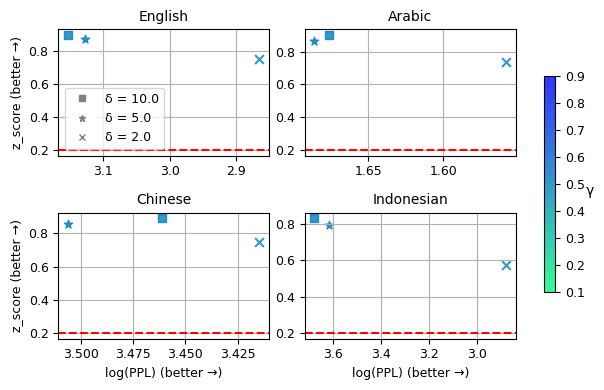

In [24]:
xsir_z_score_perplexity_scatter(ppl_type='watermarked')

In [ ]:
# Calculate self-bleu scores

def split_text(text):
    return nltk.sent_tokenize(text)

def calculate_self_bleu_scores(task = 'c4', method = 'KGW', language = 'Arabic', gen_type='watermarked'):
    df = df_dict[task][method][language]
    if gen_type == 'watermarked':
        bleu_column = 'wm_self_bleu'
    else:
        bleu_column = 'unwm_self_bleu'
    
    df[bleu_column] = [None] * len(df)
    for index, row in df.iterrows():
        bleu_scores = []

        for idx, example in enumerate(row['examples']):
            _, unwatermarked, watermarked = example
            text = watermarked if gen_type == 'watermarked' else unwatermarked
            # Calculate self-bleu scores
            sentences = split_text(text)
            # by manually splitting after a certin reasonable length if the original length <= 1
            sentences_len = len(sentences)
            if sentences_len <= 1:
                mid_point = len(text) // 2
                sentences = [text[:mid_point], text[mid_point:]]
            # bleu_scores.append(pool.apply_async(calculate_selfBleu, args=(sentences,)))
            bleu_scores.append(calculate_selfBleu(sentences))

        
        # Calculate average of scores
        df.at[index, bleu_column] = bleu_scores #sum(bleu_scores) / len(bleu_scores)

def get_bleu_score(hypothesis, references, weight):    
    return nltk.translate.bleu_score.sentence_bleu(references, hypothesis, weight, smoothing_function=SmoothingFunction().method1)



def calculate_selfBleu(sentences):
    '''
    sentences - list of sentences generated by NLG system
    '''
    ngram = 2
    weight = tuple((1. / ngram for _ in range(ngram)))
    bleu_scores = []
    hypothesises = [nltk.word_tokenize(sentence) for sentence in sentences]
    for idx, hypothesis in enumerate(hypothesises):
        references = hypothesises[:idx] + hypothesises[idx+1:]
        score = get_bleu_score(hypothesis,references, weight)
        bleu_scores.append(score)
    return np.mean(bleu_scores)

In [11]:
# call function calculate_self_bleu_scores
for task in ['c4', 'lfqa']:
# task = 'c4'
    for method in all_methods:
        print(f'Calculating self-bleu scores for task {task}, method {method}...')
        for language in languages:
            print(f'Calculating self-bleu scores for language {language}...')
            calculate_self_bleu_scores(task=task, method=method, language=language, gen_type='watermarked')
            calculate_self_bleu_scores(task=task, method=method, language=language, gen_type='unwatermarked')

Calculating self-bleu scores for task c4, method KGW...
Calculating self-bleu scores for language English...
Calculating self-bleu scores for language Arabic...
Calculating self-bleu scores for language Chinese...
Calculating self-bleu scores for language Indonesian...
Calculating self-bleu scores for task c4, method Unigram...
Calculating self-bleu scores for language English...
Calculating self-bleu scores for language Arabic...
Calculating self-bleu scores for language Chinese...
Calculating self-bleu scores for language Indonesian...
Calculating self-bleu scores for task c4, method XSIR...
Calculating self-bleu scores for language English...
Calculating self-bleu scores for language Arabic...
Calculating self-bleu scores for language Chinese...
Calculating self-bleu scores for language Indonesian...
Calculating self-bleu scores for task c4, method EXP...
Calculating self-bleu scores for language English...
Calculating self-bleu scores for language Arabic...
Calculating self-bleu sc

In [12]:
# Calculate using n-gram repetition as in https://arxiv.org/pdf/2312.04469
def compute_seq_rep_n(samples, tokenizer, n=3):
    """compute seq-rep-n metric"""
    n_gram_reps = []
    
    for s in samples:
        n_grams = []
        tokens = tokenizer(s, add_special_tokens=False).input_ids
        for i in range(len(tokens)):
            if i <= len(tokens) - n:
                n_grams.append(tuple(tokens[i:i + n]))
                    
        rep = 1 - len(set(n_grams)) / len(n_grams)
        n_gram_reps.append(rep)
            
    median_rep = np.median(n_gram_reps)
    mean_rep = np.mean(n_gram_reps)
    return {
        f"median_seq_rep_{n}": median_rep,
        f"mean_seq_rep_{n}": mean_rep,
        f"list_seq_rep_{n}": n_gram_reps,
    }


def compute_total_rep_n(samples, tokenizer, n=3):
    """compute total-rep-n metric"""
    n_grams = []
    
    for s in samples:
        tokens = tokenizer(s, add_special_tokens=False).input_ids
        for i in range(len(tokens)):
            if i <= len(tokens) - n:
                n_grams.append(tuple(tokens[i:i + n]))

    total_rep = 1 - len(set(n_grams)) / len(n_grams)        

    return {f"total_rep_{n}": total_rep}


def compute_repetition(samples_dict, tokenizer, n=3):
    """Compute repetition metrics."""
    for model_name, sd in tqdm(samples_dict.items()):
        samples = samples_dict[model_name]["model_text"]
        sd.update(compute_seq_rep_n(samples, tokenizer, n=n))
        sd.update(compute_total_rep_n(samples, tokenizer, n=n))
        print(f"Model name: {model_name}\nMedian seq rep {n}: {sd[f'median_seq_rep_{n}']}\nTotal rep {n}: {sd[f'total_rep_{n}']}")
    return sd

def compute_repetition_all_methods(task='c4', tokenizer=None, n=3):
    """Compute repetition metrics for all methods."""
    task_seq_rep_results = {}
    for method in all_methods:
        print(f"Computing repetition metrics for method: {method}, and task: {task}")
        for language in languages:
            samples_dict = {}
            df = df_dict[task][method][language]
            print(f"Computing for language: {language}")
            for index, row in df.iterrows():
                samples_dict[f"Cohere AI"] = {
                    "model_text": [example[2] for example in row['examples']]  # watermarked sample
                }
            compute_repetition(samples_dict, tokenizer, n=n)
    return task_seq_rep_results

In [18]:
tokenizer_path = "CohereForAI/c4ai-command-r7b-12-2024"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=True)
compute_repetition_all_methods(task='c4', tokenizer=tokenizer, n=3)
compute_repetition_all_methods(task='lfqa', tokenizer=tokenizer, n=3)

Computing repetition metrics for method: KGW, and task: c4
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Model name: Cohere AI
Median seq rep 3: 0.03535353535353536
Total rep 3: 0.2406782401325761
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Model name: Cohere AI
Median seq rep 3: 0.0505050505050505
Total rep 3: 0.1908803949737966
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Model name: Cohere AI
Median seq rep 3: 0.0757575757575758
Total rep 3: 0.18672497393381715
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Model name: Cohere AI
Median seq rep 3: 0.06598984771573602
Total rep 3: 0.26839362509486464
Computing repetition metrics for method: Unigram, and task: c4
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Model name: Cohere AI
Median seq rep 3: 0.045454545454545414
Total rep 3: 0.2643044062522102
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Model name: Cohere AI
Median seq rep 3: 0.06598984771573602
Total rep 3: 0.222260422881296
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Model name: Cohere AI
Median seq rep 3: 0.09090909090909094
Total rep 3: 0.23534289238983153
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Model name: Cohere AI
Median seq rep 3: 0.08080808080808077
Total rep 3: 0.27011081313565755
Computing repetition metrics for method: XSIR, and task: c4
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Model name: Cohere AI
Median seq rep 3: 0.06060606060606055
Total rep 3: 0.2152810760011722
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Model name: Cohere AI
Median seq rep 3: 0.09595959595959591
Total rep 3: 0.218326386921863
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Model name: Cohere AI
Median seq rep 3: 0.13705583756345174
Total rep 3: 0.21144754558062784
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Model name: Cohere AI
Median seq rep 3: 0.11111111111111116
Total rep 3: 0.25284562725321014
Computing repetition metrics for method: EXP, and task: c4
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Model name: Cohere AI
Median seq rep 3: 0.030303030303030276
Total rep 3: 0.21432179588207956
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Model name: Cohere AI
Median seq rep 3: 0.08585858585858586
Total rep 3: 0.29702129380598974
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Model name: Cohere AI
Median seq rep 3: 0.0835384299851305
Total rep 3: 0.32282341516705615
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Model name: Cohere AI
Median seq rep 3: 0.11868686868686867
Total rep 3: 0.3218573321331405
Computing repetition metrics for method: KGW, and task: lfqa
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Model name: Cohere AI
Median seq rep 3: 0.015151515151515138
Total rep 3: 0.1838490427399273
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Model name: Cohere AI
Median seq rep 3: 0.025252525252525304
Total rep 3: 0.24127498102706801
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Model name: Cohere AI
Median seq rep 3: 0.02056568860692576
Total rep 3: 0.15119182977341017
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Model name: Cohere AI
Median seq rep 3: 0.025252525252525304
Total rep 3: 0.17714054108825616
Computing repetition metrics for method: Unigram, and task: lfqa
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Model name: Cohere AI
Median seq rep 3: 0.016761869088865955
Total rep 3: 0.18913114619978733
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Model name: Cohere AI
Median seq rep 3: 0.025252525252525304
Total rep 3: 0.24786471826424872
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Model name: Cohere AI
Median seq rep 3: 0.025252525252525304
Total rep 3: 0.16979212242696817
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Model name: Cohere AI
Median seq rep 3: 0.030456852791878153
Total rep 3: 0.17478094000345212
Computing repetition metrics for method: XSIR, and task: lfqa
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Model name: Cohere AI
Median seq rep 3: 0.025252525252525304
Total rep 3: 0.16479446981854096
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Model name: Cohere AI
Median seq rep 3: 0.030303030303030276
Total rep 3: 0.24455147014185397
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Model name: Cohere AI
Median seq rep 3: 0.025252525252525304
Total rep 3: 0.16675125357802634
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Model name: Cohere AI
Median seq rep 3: 0.04040404040404044
Total rep 3: 0.17416935164198522
Computing repetition metrics for method: EXP, and task: lfqa
Computing for language: English


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Model name: Cohere AI
Median seq rep 3: 0.030303030303030276
Total rep 3: 0.22416016640665626
Computing for language: Arabic


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Model name: Cohere AI
Median seq rep 3: 0.048812734676609015
Total rep 3: 0.29296687837052593
Computing for language: Chinese


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Model name: Cohere AI
Median seq rep 3: 0.03535353535353536
Total rep 3: 0.1912168155283731
Computing for language: Indonesian


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

Model name: Cohere AI
Median seq rep 3: 0.0505050505050505
Total rep 3: 0.2298175889126669


{}

In [ ]:
# add a column that leverges self-bleu scores. this column calculates the following equation and it's called adjusted diversity (AD):
# AD = w X SB + (1 - w) X (1 - NC), where w is  0.3, SB is the self-bleu score and NC is the normalized coherency metric of the gpt_judge column for watermarked texts.
# NC = (coherency - 1) / (5 - 1)

def calculate_adjusted_diversity(task = 'c4', method = 'KGW', language = 'Arabic', gen_type='watermarked', weight=0.3):
    df = df_dict[task][method][language]
    if gen_type == 'watermarked':
        bleu_column = 'wm_self_bleu'
        ad_column = "wm_adjusted_diversity"
        mean_ad_column = "wm_mean_adjusted_diversity"
    else:
        bleu_column = 'unwm_self_bleu'
        ad_column = "unwm_adjusted_diversity"
        mean_ad_column = "unwm_mean_adjusted_diversity"
    
    df[ad_column] = [None] * len(df)
    df[mean_ad_column] = 0.0

    # calculate the average of self-bleu scores and coherency scores first and then calculate the adjusted diversity
    for index, row in df.iterrows():
        # Calculate the average self-bleu scores
        avg_self_bleu = np.mean(row[bleu_column])

        # Calculate the average coherency
        gpt_judge_data = row['gpt_judge']
        coherency = np.array([item[1][3] for item in gpt_judge_data]) if gen_type == 'watermarked' else np.array([item[0][3] for item in gpt_judge_data])
        avg_coherency = np.mean(coherency)

        # Calculate the normalized coherency (NC)
        NC = (avg_coherency - 1) / (5 - 1)

        # Calculate the adjusted diversity (AD)
        AD = weight * avg_self_bleu + (1 - weight) * (1 - NC)

        # Store the adjusted diversity in the dataframe
        # df.at[index, ad_column] = AD
        df.at[index, mean_ad_column] = AD

In [ ]:
# print the results of self-bleu and the mean adjusted diversity
task = 'c4'
for method in all_methods:
    for language in languages:
        print(f'Calculating adjusted diversity for method {method}, language {language}...')
        for w in [0.1, 0.3, 0.5, 0.7]:
            print(f'Calculating adjusted diversity with weight = {w}')
            calculate_adjusted_diversity(task='c4', method=method, language=language, gen_type='watermarked', weight=w)
            calculate_adjusted_diversity(task='c4', method=method, language=language, gen_type='unwatermarked', weight=w)
            df = df_dict[task][method][language]
            print(f'WATERMARKED self-bleu and AD scores')
            for index, row in df.iterrows():
                if method == "KGW" or method == "Unigram":
                    if row['gamma'] == 0.5 and row['delta'] == 2.0:
                        print(f'Gamma: {row["gamma"]}, Delta: {row["delta"]}, {round(np.mean(row["wm_self_bleu"]), 2)} {round(row["wm_mean_adjusted_diversity"], 2)}')
                elif method == "XSIR":
                    print(f'Delta: {row["delta"]}, {round(np.mean(row["wm_self_bleu"]), 2)} {round(row["wm_mean_adjusted_diversity"], 2)}')
                else:
                    print(f'{round(np.mean(row["wm_self_bleu"]), 2)} {round(row["wm_mean_adjusted_diversity"], 2)}')

            print(f'UNWATERMARKED self-bleu and AD scores')
            for index, row in df.iterrows():
                if method == "KGW" or method == "Unigram":
                    if row['gamma'] == 0.5 and row['delta'] == 2.0:
                        print(f'Gamma: {row["gamma"]}, Delta: {row["delta"]}, {round(np.mean(row["unwm_self_bleu"]), 2)} {round(row["unwm_mean_adjusted_diversity"], 2)}')
                elif method == "XSIR":
                    print(f'Delta: {row["delta"]}, {round(np.mean(row["unwm_self_bleu"]), 2)} {round(row["unwm_mean_adjusted_diversity"], 2)}')
                else:
                    print(f'{round(np.mean(row["unwm_self_bleu"]), 2)} {round(row["unwm_mean_adjusted_diversity"], 2)}')
            print()

Calculating adjusted diversity for method KGW, language English...
Calculating adjusted diversity with weight = 0.1
WATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.21 0.34
UNWATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.22 0.35

Calculating adjusted diversity with weight = 0.3
WATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.21 0.31
UNWATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.22 0.32

Calculating adjusted diversity with weight = 0.5
WATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.21 0.28
UNWATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.22 0.29

Calculating adjusted diversity with weight = 0.7
WATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.21 0.26
UNWATERMARKED self-bleu and AD scores
Gamma: 0.5, Delta: 2.0, 0.22 0.26

Calculating adjusted diversity for method KGW, language Arabic...
Calculating adjusted diversity with weight = 0.1
WATERMARKED self-bleu and AD scores
Gamma: 0.5, De

In [ ]:
# Trying to put all figures in one plot
# relate z_scores and perplexities for only watermarked text
def kgw_family_relate_z_scores_selfBlue_all(method = 'KGW', self_bleu_type='watermarked'):
    if self_bleu_type == 'watermarked':
        index = 2
        avg_z_scores_col_name = "wm_avg_z_scores"
        selfBleu_col_name = "wm_self_bleu"
    elif self_bleu_type == 'unwatermarked':
        index = 1
        avg_z_scores_col_name = "unwm_avg_z_scores"
        selfBleu_col_name = "unwm_self_bleu"

    languages = ["English", "Arabic", "Chinese", "Indonesian"]
    save_path = f'figures/{method}/z_scores_selfBleu_all_{method}_{self_bleu_type}.pdf'

    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(19, 15))
    gamma_norm = mcolors.Normalize(vmin=0.1, vmax=0.9)
    cmap = cm.winter_r # last was winter_r
    

    # Adding delta markers
    markers = ['o', 'x', '*']
    handles = []
    dataframes = [df_dict[method]['English'], df_dict[method]['Arabic'], df_dict[method]['Chinese'], df_dict[method]['Indonesian']]
    for idx, (language, df) in enumerate(zip(languages, dataframes)):
        # check if column avg_z_scores_col_name exists
        if avg_z_scores_col_name not in df.columns:
            df[avg_z_scores_col_name] = df['z_scores'].apply(lambda x: np.mean([item[index] for item in x]))
        df['avg_selfBleu'] = df[selfBleu_col_name].apply(lambda x: np.mean(x))
        ax = axes[idx // 2, idx % 2]
        scatter = ax.scatter(df['avg_selfBleu'], df[avg_z_scores_col_name],
                            c=df['gamma'], norm=gamma_norm, cmap=cmap, s=300,
                            alpha=0.8,
                            marker='none')

        ims = []
        for i, delta in enumerate(sorted(df['delta'].unique())):
            subset = df[df['delta'] == delta]
            pts = ax.scatter(subset['avg_selfBleu'], subset[avg_z_scores_col_name],
                            c=subset['gamma'], norm=gamma_norm, cmap=cmap, s=300,
                            alpha=0.8, marker=markers[i])
            # handles.append(pts) # no need for this, we don't seem to use it.
            ims.append(pts)

        if idx == 2 or idx == 3:
            ax.set_xlabel('Self-Bleu (more diverse →)', fontsize=32)
        if idx == 0 or idx == 2:
            ax.set_ylabel('z_score (better →)', fontsize=32)

        ax.set_title(f'{language}', fontsize=32)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.invert_xaxis()

        # Threshold line at z_score = 4
        ax.axhline(y=4, color='red', linestyle='--')

        # Create a custom legend with gray markers
        custom_handles = [
        plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markeredgecolor='gray', markersize=20, label=f'δ = {delta}')
        for m, delta in zip(markers, sorted(df['delta'].unique()))
        ]
        ax.legend(handles=custom_handles, loc='best', reverse=True, fontsize=25)
        ax.grid(True)

    cbar = fig.colorbar(ims[0], ax=axes.ravel().tolist(), shrink=0.7)
    cbar.set_label('γ', rotation=0)
    # make the colorbar tick labels bigger
    cbar.ax.tick_params(labelsize=25)

    # plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

In [ ]:
# XSIR
def xsir_z_score_selfBleu_scatter(self_bleu_type='watermarked'):
    if self_bleu_type == 'watermarked':
        index = 2
        avg_z_scores_col_name = "wm_avg_z_scores"
        selfBleu_col_name = "wm_self_bleu"
        avg_selfBleu_col_name = "avg_wm_self_bleu"
    elif self_bleu_type == 'unwatermarked':
        index = 1
        avg_z_scores_col_name = "unwm_avg_z_scores"
        selfBleu_col_name = "unwm_self_bleu"
        avg_selfBleu_col_name = "avg_unwm_self_bleu"
    save_path = f'figures/XSIR/z_score_selfBleu_xsir_all_langs_{self_bleu_type}.pdf'
    fig, axes = plt.subplots(2, 2, figsize=(19, 15))
    cmap = cm.winter_r
    norm = plt.Normalize(vmin=0.4, vmax=0.6)  # Example color range
    markers = ['o', 'x', '*']
    handles = []
    method = 'XSIR'
    dfs = df_dict[method]
    for idx, (lang, df) in enumerate(dfs.items()):
        # avg_z_scores_col_name doesn't exist yet calculate it
        if avg_z_scores_col_name not in df.columns:
            df[avg_z_scores_col_name] = df['z_scores'].apply(lambda x: np.mean([item[index] for item in x]))
        if avg_selfBleu_col_name not in df.columns:
            df[avg_selfBleu_col_name] = df[selfBleu_col_name].apply(lambda x: np.mean(x))
        ax = axes[idx // 2, idx % 2]
        scatter = ax.scatter(df[avg_selfBleu_col_name], df[avg_z_scores_col_name],
                            c=[0.5]*len(df[avg_selfBleu_col_name]), norm=norm, cmap=cmap, s=300,
                            alpha=0.8,
                            marker='none')
        
        for i, delta in enumerate(sorted(df['delta'].unique())):
            subset = df[df['delta'] == delta]
            pts = ax.scatter(subset[avg_selfBleu_col_name], subset[avg_z_scores_col_name],
                            c=[0.5]*len(subset), norm=norm, cmap=cmap, s=300,
                            alpha=0.8, marker=markers[i])


        if idx == 2 or idx == 3:
            ax.set_xlabel('selfBleu (more diverse →)', fontsize=32)
        if idx == 0 or idx == 2:
            ax.set_ylabel('z_score (better →)', fontsize=32)
            
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_title(f'{lang}', fontsize=32)
        ax.invert_xaxis()

        # Threshold line at z_score = 4
        ax.axhline(y=0.2, color='red', linestyle='--')

        # Create a custom legend with gray markers
        custom_handles = [
        plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markeredgecolor='gray', markersize=15, label=f'δ = {delta}')
        for m, delta in zip(markers, sorted(df['delta'].unique()))
        ]
        ax.legend(handles=custom_handles, loc='best', reverse=True, fontsize=25)
        ax.grid(True)

    cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), shrink=0.7)
    cbar.set_label('γ', rotation=0)
    # make the colorbar tick labels bigger
    cbar.ax.tick_params(labelsize=20)

    # plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

In [ ]:
# EXP
# relate p_values to perplexity by create a scatter plot of p-values as a function of perplexity
def exp_pvalues_selfBleu_scatter(gen_type='watermarked'):
    # if gen_type == 'watermarked':
    #     bleu_column = 'wm_self_bleu'
    #     idx = 2
    # else:
    #     bleu_column = 'unwm_self_bleu'
    #     idx = 1

    wm_bleu_column = 'wm_self_bleu'
    unwm_bleu_column = 'unwm_self_bleu'
    # Set up the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(19, 15), sharey=True)
    # fig.suptitle(f'Distribution of Log Perplexity Values for {langauge} Text', fontsize=16)
    save_path = f'figures/EXP/pvals_selfbleu_exp_all_langs.pdf'
    method = 'EXP'
    # Create boxplots for each language
    for i, language in enumerate(languages):
        ax = axes[i//2, i%2]
        data_subset = df_dict[method][language]
        # data_subset = copy.deepcopy(df[df['language'] == language])
        # Extract perplexity values
        # perplexity_values = np.array(data_subset) # Transpose to get perplexity for gold, unwatermarked, and watermarked
        wm_selfbleu = []
        unwm_selfbleu = []
        wm_pvalues = []
        unwm_pvalues = []

        for index, row in data_subset.iterrows():
            for (unwm_bleu_scores, wm_bleu_scores, pval) in zip(row[unwm_bleu_column], row[wm_bleu_column], row['pvals']):
                unwm_pval, wm_pval = pval[1], pval[2]
                unwm_pvalues.append(unwm_pval)
                wm_pvalues.append(wm_pval)
                unwm_selfbleu.append(unwm_bleu_scores)
                wm_selfbleu.append(wm_bleu_scores)
                # get the confidence values instead by inverting the pvalues

        ax.scatter(unwm_selfbleu, unwm_pvalues, label='Unwatermarked', s=300)
        ax.scatter(wm_selfbleu, wm_pvalues, label='Watermarked', s=300)
        ax.set_title(f'{language}', fontsize=32)
        if i == 2 or i ==3:
            ax.set_xlabel('selfBlue (more diverse →)', fontsize=32)
        if i == 0 or i == 2:
            ax.set_ylabel('(better ←) pvalues', fontsize=32)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.axhline(y=10e-5, color='r', linestyle='--', label='Threshold 10-e5')
        ax.legend(loc='best', reverse=True, fontsize=25)

    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

In [ ]:
kgw_family_relate_z_scores_selfBlue_all(method="KGW", self_bleu_type='watermarked')
kgw_family_relate_z_scores_selfBlue_all(method="Unigram", self_bleu_type='watermarked')
xsir_z_score_selfBleu_scatter(self_bleu_type='watermarked')
exp_pvalues_selfBleu_scatter(gen_type='watermarked')

In [18]:
def calculate_precision_rates(z_scores_list, threshold=4.0, method = 'KGW'):
    # Initialize counts
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    # Process each set of z-scores for gold, unwatermarked, and watermarked
    for z in z_scores_list:
        gold, unwm, wm = z

        if method == "KGW" or method == "Unigram":
            # Check conditions
            if unwm >= threshold:
                false_positive += 1
            else:
                true_negative += 1
            
            if wm < threshold:
                false_negative += 1
            else:
                true_positive += 1
        elif method == 'XSIR':
            # Check conditions
            if unwm >= threshold:
                false_positive += 1
            else:
                true_negative += 1

            if wm < threshold:
                false_negative += 1
            else:
                true_positive += 1

        else: # EXP
            # Check conditions
            if unwm <= threshold:
                false_positive += 1
            else:
                true_negative += 1

            if wm > threshold:
                false_negative += 1
            else:
                true_positive += 1

    # Calculate rates
    TPR = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    FPR = false_positive / (false_positive + true_negative) if (false_positive + true_negative) != 0 else 0
    FNR = false_negative / (false_negative + true_positive) if (false_negative + true_positive) != 0 else 0
    TNR = true_negative / (true_negative + false_positive) if (true_negative + false_positive) != 0 else 0
    return TPR, TNR, FPR, FNR

In [19]:
# Iterate over DataFrame and calculate error rates
for method in df_dict.keys():
    threshold = 4
    scores_col_name = 'z_scores'
    if method == "XSIR":
        threshold = 0.2
    elif method == "EXP":
        threshold = 0.0001 # 10e-5
        scores_col_name = 'pvals'
    for lang, df in df_dict[method].items():
        df[['TPR', 'TNR', 'FPR', 'FNR']] = df[scores_col_name].apply(lambda z_scores_list: pd.Series(calculate_precision_rates(z_scores_list, threshold, method)))

In [ ]:
for method, dict_vals in df_dict.items():
    for language, df in dict_vals.items():
        print(f'{method} {language}:\n', df[['TPR', 'TNR', 'FPR', 'FNR']])

KGW English:
      TPR  TNR  FPR    FNR
0  0.854  1.0  0.0  0.146
KGW Arabic:
      TPR  TNR  FPR    FNR
0  0.834  1.0  0.0  0.166
KGW Chinese:
      TPR    TNR    FPR    FNR
0  0.942  0.998  0.002  0.058
KGW Indonesian:
      TPR  TNR  FPR    FNR
0  0.972  1.0  0.0  0.028
Unigram English:
     TPR  TNR  FPR   FNR
0  0.49  1.0  0.0  0.51
Unigram Arabic:
      TPR  TNR  FPR    FNR
0  0.568  1.0  0.0  0.432
Unigram Chinese:
      TPR    TNR    FPR    FNR
0  0.956  0.988  0.012  0.044
Unigram Indonesian:
      TPR  TNR  FPR    FNR
0  0.616  1.0  0.0  0.384
EXP English:
     TPR  TNR  FPR   FNR
0  0.98  1.0  0.0  0.02
EXP Arabic:
      TPR  TNR  FPR    FNR
0  0.996  1.0  0.0  0.004
EXP Chinese:
    TPR  TNR  FPR  FNR
0  1.0  1.0  0.0  0.0
EXP Indonesian:
    TPR  TNR  FPR  FNR
0  1.0  1.0  0.0  0.0
XSIR English:
      TPR  TNR  FPR    FNR
0  0.958  1.0  0.0  0.042
XSIR Arabic:
      TPR   TNR   FPR    FNR
0  0.994  0.92  0.08  0.006
XSIR Chinese:
      TPR    TNR    FPR    FNR
0  0.996  0.

In [ ]:
from sklearn.metrics import roc_curve, auc

# smaller figures
def kgw_family_plot_roc_curves_all(task = 'c4', fpr_range=(0.0, 0.15), suffix=""):
    for method in ['KGW', 'Unigram']:
        language_dataframes = df_dict[task][method]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.5, 6))
        low, high = fpr_range
        save_path = f'figures/{method}/roc_curves_all_{method}_{suffix}.pdf'
        for index, (language, df) in enumerate(language_dataframes.items()):
            ax = axes[index // 2, index % 2]
            for i, row in df.iterrows():
                # if (row['gamma'] == 0.1 and row['delta'] == 2.0) or \
                #     (row['gamma'] == 0.9 and row['delta'] == 2.0) or \
                #     (row['gamma'] == 0.1 and row['delta'] == 10.0):
                # if row['delta'] == 2.0:
                z_scores = np.array(row.z_scores)
                y_true = np.concatenate((np.zeros(500), np.ones(500)))
                y_scores = np.hstack([z_scores[:, 1], z_scores[:, 2]])
                fpr, tpr, thresholds = roc_curve(y_true, y_scores)
                roc_auc = auc(fpr, tpr)
                # avg_ppl = math.log(np.mean([ppl[1] for ppl in row.perplexity]))
                # label = f"γ:{row.gamma}, δ:{row.delta} (AUC:{roc_auc:.2f}, log(PPL):{avg_ppl:.2f})"
                # ax.plot(fpr, tpr, lw=2, label=label)
                # no ppl
                label = f"γ:{row.gamma}, δ:{row.delta} (AUC:{roc_auc:.2f})"
                ax.plot(fpr, tpr, lw=2, label=label)
                # else:
                #     continue
            ax.set_title(f'{language}', fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.plot([0, high], [0, high], color='navy', lw=2, linestyle='--')
            ax.set_xlim([low, high])  # Set x-axis limits to zoom in
            ax.set_ylim([0, 1.05])  # Adjust y-axis to focus on higher TPR values

            if index == 2 or index == 3:
                ax.set_xlabel('FPR', fontsize=10)
            if index == 0 or index == 2:
                ax.set_ylabel('TPR', fontsize=10)

            ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.55), ncol=1, fontsize=7)
            # ax.legend(loc="best", fontsize=23)
            ax.grid(True)
            
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.tight_layout()
        # plt.savefig(save_path, format='pdf')
        plt.show()

In [ ]:
def xsir_plot_roc_curves_all(task='c4', fpr_range=(0.0, 1.0), suffix=""):
    low, high = fpr_range
    method = 'XSIR'
    save_path = f'figures/{method}/roc_curves_{method}_with_legend_on_top_{suffix}.pdf'
    language_dataframes = df_dict[task][method]
    fig = plt.figure(figsize=(6.5, 5))

    gs = fig.add_gridspec(3, 2, height_ratios=[0.5, 1.3, 1.3])  # Make first row shorter

    # Adjust subplot spacing
    plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.4, wspace=0.3)

    for index, (language, df) in enumerate(language_dataframes.items()):
        ax = fig.add_subplot(gs[(index // 2)+1, index % 2])
        for i, row in df.iterrows():
            z_scores = np.array(row.z_scores)
            y_true = np.concatenate((np.zeros(500), np.ones(500)))
            y_scores = np.hstack([z_scores[:, 1], z_scores[:, 2]])
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            label = f'δ:{row.delta} (AUC:{roc_auc:.2f})'
            ax.plot(fpr, tpr, lw=2, label=label)

        ax.set_title(f'{language}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.plot([0, high], [0, high], color='navy', lw=2, linestyle='--')
        ax.set_xlim([low, high])
        ax.set_ylim([0, 1.05])
        if index == 2 or index == 3:
            ax.set_xlabel('FPR', fontsize=10)
        ax.set_ylabel('TPR', fontsize=10)
        ax.grid(True)

    # Add legend to the first row spanning both columns
    handles, labels = ax.get_legend_handles_labels()

    # Add legend to entire first row
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), 
            ncol=3, fontsize=10, bbox_transform=fig.transFigure)

    # plt.savefig(save_path, format='pdf')
    plt.tight_layout()

    plt.show()

In [14]:
# EXP
def exp_plot_roc_curves_all(task = 'c4', fpr_range=(0.0, 1.0), suffix=""):
    low, high = fpr_range
    method = 'EXP'
    save_path = f'figures/{method}/roc_curves_{method}_with_legend_on_top_{suffix}.pdf'
    fig = plt.figure(figsize=(6.5, 5))
    # fig.set_size_inches(6.5, 5)  # Adjust overall figure size
    gs = fig.add_gridspec(3, 2, height_ratios=[0.5, 1.3, 1.3])  # Make first row shorter

    # Adjust subplot spacing
    plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.4, wspace=0.3)
    # fig.suptitle(f'ROC Curves for {method} Method Across All Languages', fontsize=16)
    lang_df = df_dict[task][method]
    all_handles = []
    all_labels = []
    for index, (language, df) in enumerate(lang_df.items()):
        ax = fig.add_subplot(gs[(index // 2)+1, index % 2])
        for i, row in df.iterrows():
            pvalues = np.array(row['pvals'])
            y_true = np.concatenate((np.zeros(500), np.ones(500)))
            y_scores = np.hstack([pvalues[:, 1], pvalues[:, 2]])
            # inverting pvalues
            y_scores = -y_scores
            fpr, tpr, thresholds = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            label = f"{language} (AUC:{roc_auc:.2f})"#, log(PPL):{avg_ppl:.2f})"
            ax.plot(fpr, tpr, lw=2, label=label)

        ax.set_title(f'{language}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.plot([0, high], [0, high], color='navy', lw=2, linestyle='--')
        ax.set_xlim([low, high])
        ax.set_ylim([0, 1.05])
        if index == 2 or index == 3:
            ax.set_xlabel('FPR', fontsize=10)
        ax.set_ylabel('TPR', fontsize=10)
        ax.grid(True)

        # Collect handles and labels for the legend
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)

    # Add legend to the first row spanning both columns
    fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), 
               ncol=2, fontsize=10, bbox_transform=fig.transFigure)

    # plt.savefig(save_path, format='pdf')
    plt.tight_layout()

    plt.show()


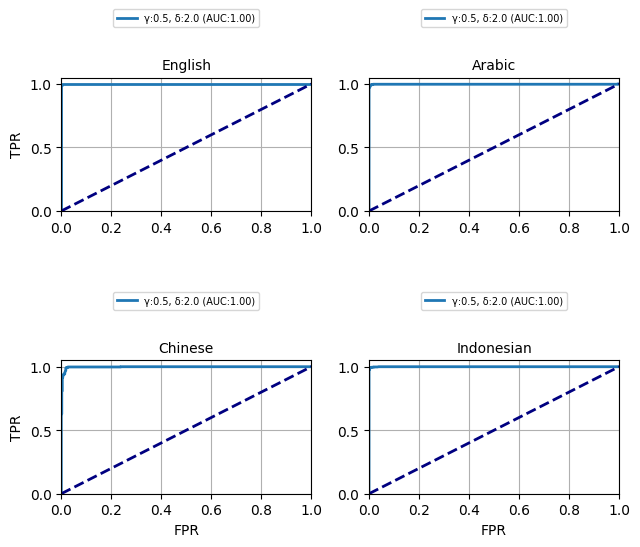

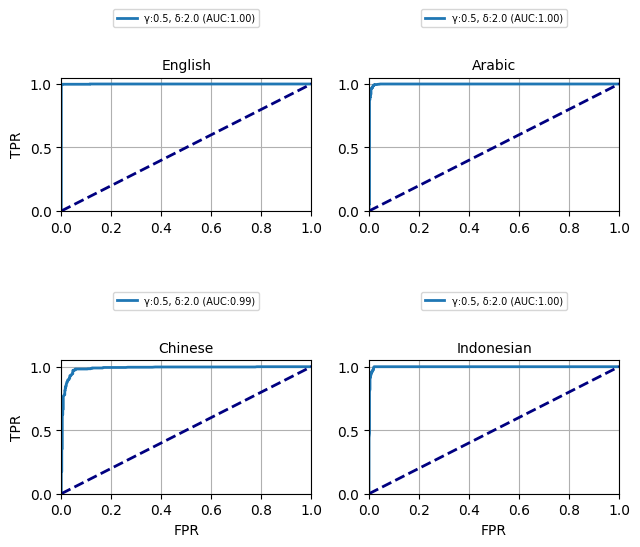

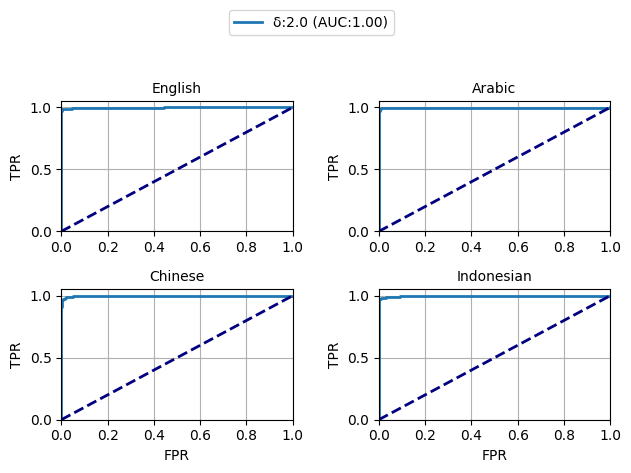

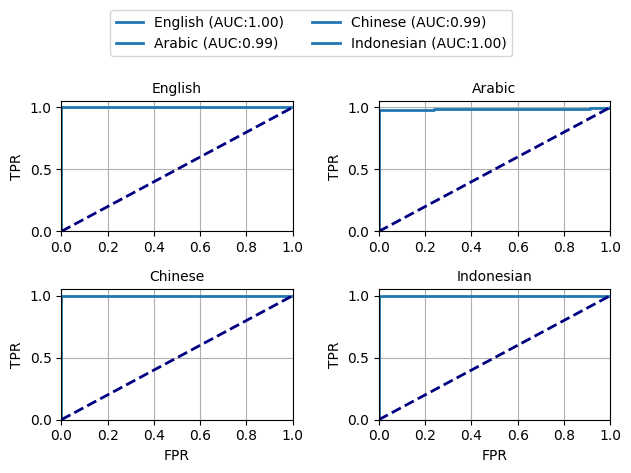

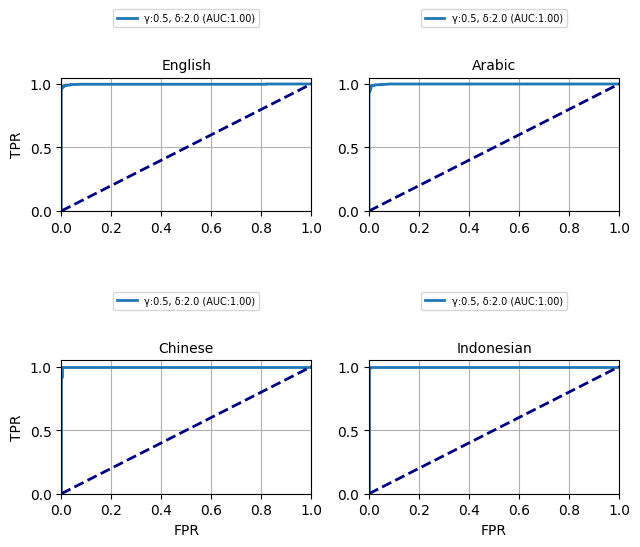

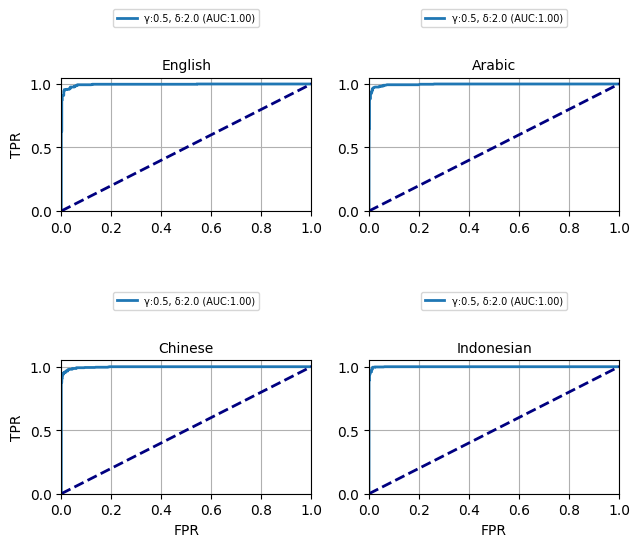

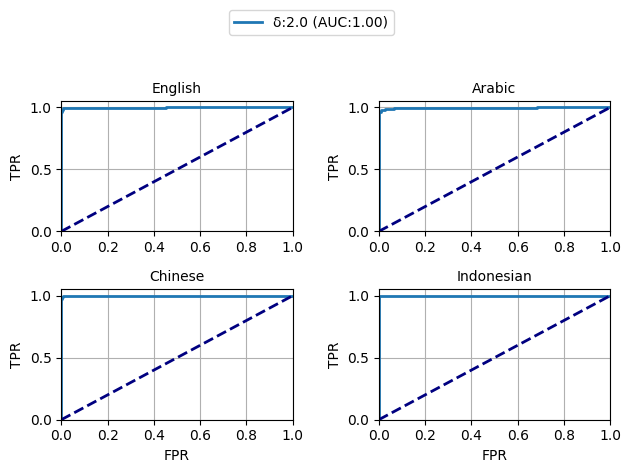

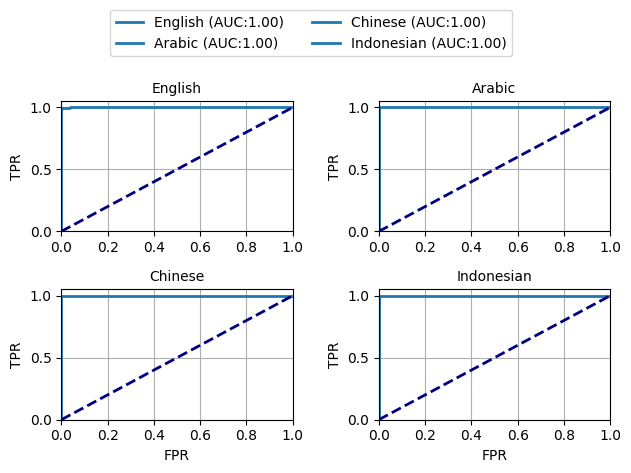

In [16]:
# task c4
kgw_family_plot_roc_curves_all(fpr_range=(0.0, 1), suffix="single_gamma_delta")
xsir_plot_roc_curves_all(fpr_range=(0.0, 1), suffix="")
exp_plot_roc_curves_all(fpr_range=(0.0, 1), suffix="")

# task lfqa
kgw_family_plot_roc_curves_all(task='lfqa', fpr_range=(0.0, 1), suffix="single_gamma_delta")
xsir_plot_roc_curves_all(task='lfqa', fpr_range=(0.0, 1), suffix="")
exp_plot_roc_curves_all(task='lfqa', fpr_range=(0.0, 1), suffix="")

In [ ]:
# calculate the TPR@FPR=0.1
def calculate_tpr_at_fpr(data, language, method, fpr_threshold=0.01):
    tpr_at_fpr = []
    z_scores_col_name = 'z_scores'
    if method == 'EXP':
        z_scores_col_name = 'pvals'
    for idx, row in data.iterrows():
        z_scores = np.array(row[z_scores_col_name])
        # Assuming binary classification for watermark detection
        # Here `y_true` can be generated assuming gold = 0, unwatermarked = 0, watermarked = 1
        # Generate labels and prediction scores
        # y_true = np.hstack([[0]*500, [1]*500])  # 500 unwatermarked, 500 watermarked
        y_true = np.concatenate((np.zeros(500), np.ones(500)))
        
        y_scores = np.hstack([z_scores[:, 1], z_scores[:, 2]])
        if method == 'EXP':
            # Invert p-values for ROC curve
            y_scores = -y_scores
        
        # Calculate ROC Curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        
        # Find the TPR at the closest threshold to fpr_threshold %
        target_fpr_index = np.where(fpr <= fpr_threshold)[0][-1]

        # TPR at the closest threshold to fpr_threshold %
        tpr_at_fpr.append(tpr[target_fpr_index])


        # Another method with same results
        # Extract unwatermarked and watermarked scores
        # unwatermarked_scores = np.array([scores[1] for scores in z_scores])
        # watermarked_scores = np.array([scores[2] for scores in z_scores])

        # # Calculate the 99th percentile value from the unwatermarked scores for the threshold
        # threshold = np.percentile(unwatermarked_scores, 100 - fpr_threshold * 100)

        # # Calculate TPR: Fraction of watermarked scores above the threshold
        # true_positive_count = np.sum(watermarked_scores > threshold)
        # total_watermarked_count = len(watermarked_scores)
        # tpr_at_fpr.append(true_positive_count / total_watermarked_count)
        if method == "KGW" or method == "Unigram":
            print(f'{method} {language}: TPR at FPR {fpr_threshold} for gamma={row["gamma"]}, delta={row["delta"]}: {tpr_at_fpr[-1]}')
        elif method == "XSIR":
            print(f'{method} {language}: TPR at FPR {fpr_threshold} for delta={row["delta"]}: {tpr_at_fpr[-1]}')
        else:
            print(f'{method} {language}: TPR at FPR {fpr_threshold} {tpr_at_fpr[-1]}')

    return tpr_at_fpr

In [21]:
task = 'lfqa'
print(f'Calculating TPR at FPR=0.01 for task {task}...')
for method, dict_vals in df_dict[task].items():
    print(f'Calculating TPR at FPR=0.01 for method {method}...')
    for language, df in dict_vals.items():
        print(f'Calculating TPR at FPR=0.01 for language {language} and with fPR threshold 0.001')
        calculate_tpr_at_fpr(df, language, method, fpr_threshold=0.001)
        print(f'Calculating TPR at FPR=0.01 for language {language} and with fPR threshold 0.01')
        calculate_tpr_at_fpr(df, language, method, fpr_threshold=0.01)


Calculating TPR at FPR=0.01 for task lfqa...
Calculating TPR at FPR=0.01 for method KGW...
Calculating TPR at FPR=0.01 for language English and with fPR threshold 0.001
KGW English: TPR at FPR 0.001 for gamma=0.5, delta=2.0: 0.958
Calculating TPR at FPR=0.01 for language English and with fPR threshold 0.01
KGW English: TPR at FPR 0.01 for gamma=0.5, delta=2.0: 0.984
Calculating TPR at FPR=0.01 for language Arabic and with fPR threshold 0.001
KGW Arabic: TPR at FPR 0.001 for gamma=0.5, delta=2.0: 0.936
Calculating TPR at FPR=0.01 for language Arabic and with fPR threshold 0.01
KGW Arabic: TPR at FPR 0.01 for gamma=0.5, delta=2.0: 0.986
Calculating TPR at FPR=0.01 for language Chinese and with fPR threshold 0.001
KGW Chinese: TPR at FPR 0.001 for gamma=0.5, delta=2.0: 0.918
Calculating TPR at FPR=0.01 for language Chinese and with fPR threshold 0.01
KGW Chinese: TPR at FPR 0.01 for gamma=0.5, delta=2.0: 0.998
Calculating TPR at FPR=0.01 for language Indonesian and with fPR threshold 0.00



| Method   | Language    | TPR@FPR=0.1% | TPR@FPR=1% |
|----------|-------------|--------------|------------|
| KGW      | English     | 0.958        | 0.984      |
| KGW      | Arabic      | 0.936        | 0.986      |
| KGW      | Chinese     | 0.918        | 0.998      |
| KGW      | Indonesian  | 0.990        | 1.000      |
| Unigram  | English     | 0.626        | 0.944      |
| Unigram  | Arabic      | 0.648        | 0.938      |
| Unigram  | Chinese     | 0.876        | 0.954      |
| Unigram  | Indonesian  | 0.894        | 0.980      |
| EXP      | English     | 0.990        | 0.992      |
| EXP      | Arabic      | 1.000        | 1.000      |
| EXP      | Chinese     | 1.000        | 1.000      |
| EXP      | Indonesian  | 1.000        | 1.000      |
| XSIR     | English     | 0.964        | 0.992      |
| XSIR     | Arabic      | 0.866        | 0.976      |
| XSIR     | Chinese     | 0.970        | 0.994      |
| XSIR     | Indonesian  | 0.994        | 1.000      |

In [ ]:
from matplotlib.patches import Patch

def plot_gpt_judge_avgs(task = 'c4', method = "KGW"):
    average_watermarked = {}
    average_unwatermarked = {}
    languages_dict = df_dict[task][method]
    languages_data = {language: languages_dict[language]["gpt_judge"] for language in languages_dict}
    save_path = f'figures/{method}/gpt_judge_avgs_{method}_small.pdf'
    for language in languages_data.keys():
        data = languages_data[language]
        average_unwatermarked[language] = np.mean([entry[0] for item in data for entry in item], axis=0)
        average_watermarked[language] = np.mean([entry[1] for item in data for entry in item], axis=0)
    # print(average_unwatermarked['English'])
    criteria = [
        "Relevance", "Detail", "Clarity", "Coherence",
        "Originality", "Examples", "Accuracy"
    ]
    languages = list(languages_data.keys())
    colors = ['green', 'teal', 'orange', 'blue']
    x = np.arange(len(criteria))
    width = 0.20

    fig, ax = plt.subplots(figsize=(4, 3))

    # Compute the maximum difference and criterion
    max_diff = 0
    most_affected_criterion = None

    for i in range(len(criteria)):
        total_difference = sum(
            average_unwatermarked[lang][i] - average_watermarked[lang][i] for lang in languages
        )
        if total_difference > max_diff:
            max_diff = total_difference
            most_affected_criterion = i

    # Plotting the bars with skewers
    for i, (lang, color) in enumerate(zip(languages, colors)):
        wm_bars = ax.bar(x + i * width, average_watermarked[lang], width, label=f'{lang} Watermarked', color=color, hatch='//')
        uwm_bars = ax.bar(x + i * width, average_unwatermarked[lang], width, label=f'{lang} Unwatermarked', color=color, alpha=0.7)

        for idx, (wm_bar, uwm_bar) in enumerate(zip(wm_bars, uwm_bars)):
            wm_height = wm_bar.get_height()
            uwm_height = uwm_bar.get_height()
            # if idx == most_affected_criterion:
            ax.plot([wm_bar.get_x() + wm_bar.get_width()/2, wm_bar.get_x() + wm_bar.get_width()/2],
                    [wm_height, uwm_height], color=('red' if idx == most_affected_criterion else 'black'), linewidth=1)

            difference = uwm_height - wm_height
            # display only the text for the most affected criterion
            ax.text(wm_bar.get_x() + wm_bar.get_width()/2, uwm_height + 0.05,
                    f'{difference:.2f}', ha='center', va='bottom', fontsize=5, fontweight='bold',
                    color=('red' if idx == most_affected_criterion else 'black'))

    # Create custom legend entries
    legend_patches = [
        Patch(facecolor=color, edgecolor='k', label=f'{lang}', alpha=0.7) for lang, color in zip(languages, colors)
    ] + [
        Patch(facecolor='none', edgecolor='k', label='Unwatermarked'),
        Patch(facecolor='none', edgecolor='k', label='Watermarked', hatch='//'),
    ]
    ax.legend(handles=legend_patches, loc='lower right', fontsize=8)

    ax.set_ylabel('Average Scores', fontsize=9)
    ax.set_xticks(x + width * (len(languages) / 2 - 0.5))
    ax.set_xticklabels(criteria, rotation=30, ha='right')
    ax.tick_params(axis='both', which='major', labelsize=8)
    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

def plot_gpt_judge_clarity_coherence(task = 'c4', method="KGW", suffix=""):
    average_watermarked = {}
    average_unwatermarked = {}
    languages_dict = df_dict[task][method]
    # languages_data = {language: languages_dict[language]["gpt_judge"] for language in languages_dict}
    if method == "KGW" or method == "Unigram":
        languages_data = { # for speicifc gamma and delta
            language: languages_dict[language].loc[
                (languages_dict[language]['gamma'] == 0.5) & (languages_dict[language]['delta'] == 2.0), 'gpt_judge'
            ].tolist()
            for language in languages_dict
        }

    elif method == "XSIR": # only consider delta
        languages_data = { # for speicifc gamma and delta
            language: languages_dict[language].loc[languages_dict[language]['delta'] == 2.0, 'gpt_judge'].tolist()
            for language in languages_dict
        }
    else:
    # the following line is for all gammas and deltas
        languages_data = {language: languages_dict[language]["gpt_judge"].tolist() for language in languages_dict}
    # print(languages_data)
    save_path = f'figures/{method}/gpt_judge_avgs_{method}_small_{suffix}.pdf'
    for language in languages_data.keys():
        data = languages_data[language]
        # Select relevance (index 0), clarity (index 2) and coherence (index 3)
        criteria_indices = [0, 2, 3]
        ################################################
        # for debugging only
        # for idx, item in enumerate(data):
        #     for inner_idx, entry in enumerate(item):
        #         print(f"entry {inner_idx}: {entry}")
        #         if len(entry[0]) < 7 or len(entry[1]) < 7:
        #             print(f"Warning: Entry for {language} is too short: {entry} at index {idx}")
        #         print(f"Task {task} Method {method} Entry {idx} for {language}: {entry}")
        #         print(entry[0], entry[1])
        ################################################
        average_unwatermarked[language] = np.mean([np.array(entry[0])[criteria_indices] for item in data for entry in item], axis=0)
        average_watermarked[language] = np.mean([np.array(entry[1])[criteria_indices] for item in data for entry in item], axis=0)


    criteria = ["Relevance", "Clarity", "Coherence"]
    languages = list(languages_data.keys())
    line_styles = ['-', '--', ':', '-.', '--', ':']
    
    # fig, ax = plt.subplots(figsize=(4, 3))
    fig = plt.figure(figsize=(4, 3))
    # fig.set_size_inches(6.5, 5)  # Adjust overall figure size
    gs = fig.add_gridspec(2, 1, height_ratios=[0.08, 1.3])  # Make first row shorter

    # Adjust subplot spacing
    plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95, hspace=0.4, wspace=0.3)
    ax = fig.add_subplot(gs[1])
    for i, (lang, style) in enumerate(zip(languages, line_styles)):
        differences = (average_unwatermarked[lang] - average_watermarked[lang]) / average_unwatermarked[lang] * 100
        print(f"{lang} differences percentage: {differences}")
        ax.plot(criteria, differences, label=lang, linestyle=style, marker='o', linewidth=2)

    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax.set_ylabel('Score Difference %\n(Unwatermarked - Watermarked)', fontsize=9)
    ax.grid(True, alpha=0.3)

    fig.legend(loc='upper center', bbox_transform=fig.transFigure, ncol=4, fontsize=8)
    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()


English differences percentage: [0.77120823 0.75225677 1.17167601]
Arabic differences percentage: [2.38353196 1.86046512 2.90322581]
Chinese differences percentage: [0.70957932 1.04321908 1.25691302]
Indonesian differences percentage: [0.92272203 3.03852415 2.26628895]
Turkish differences percentage: [4.02459475 4.05476567 6.7139738 ]
Hindi differences percentage: [7.51138088 7.38950276 8.20668693]


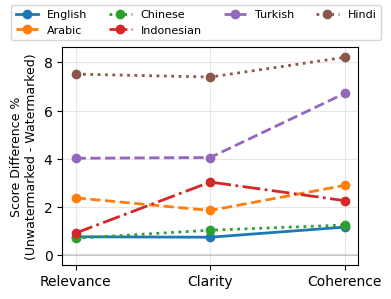

English differences percentage: [0.71905496 0.20090407 0.76452599]
Arabic differences percentage: [3.86652542 1.98979592 3.68227249]
Chinese differences percentage: [3.14371257 2.40549828 3.43283582]
Indonesian differences percentage: [5.94227504 7.29613734 7.3971079 ]
Turkish differences percentage: [5.10260677 4.90765172 6.63377193]
Hindi differences percentage: [17.86786787 17.85714286 19.94025392]


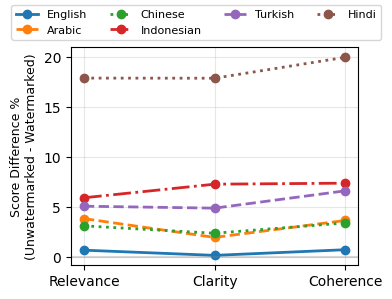

English differences percentage: [15.27020327 12.82301316 16.22287968]
Arabic differences percentage: [13.2808399   9.80592441 15.24804178]
Chinese differences percentage: [8.51485149 6.28961482 8.71491876]
Indonesian differences percentage: [16.90687361 17.70005299 19.6099675 ]
Turkish differences percentage: [19.05793178 18.66178777 22.91334397]
Hindi differences percentage: [38.08139535 36.90958165 40.0287977 ]


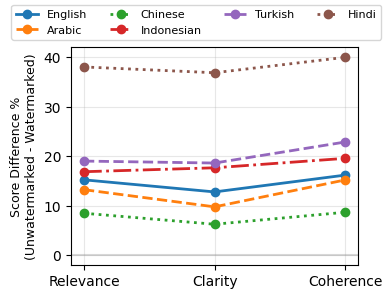

English differences percentage: [1.32113821 1.4449427  1.76322418]
Arabic differences percentage: [-1.13697888 -0.51706308 -0.91447015]
Chinese differences percentage: [2.55383075 1.72924901 2.20551378]
Indonesian differences percentage: [13.52112676 14.94376004 17.20725673]
Turkish differences percentage: [35.20678685 33.24847251 38.30561331]
Hindi differences percentage: [ 2.75157233 -0.3615329   2.21518987]


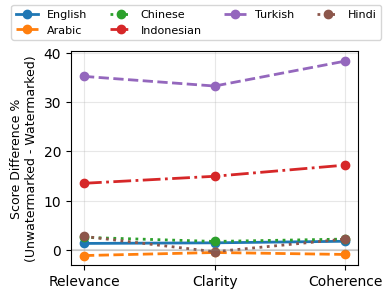

English differences percentage: [-1.67264038 -0.97879282 -1.75537939]
Arabic differences percentage: [16.40625    13.79501385 16.67631731]
Chinese differences percentage: [4.60797799 4.58598726 5.66534914]
Indonesian differences percentage: [6.         5.48025928 7.48466258]
Turkish differences percentage: [8.30564784 6.13873542 8.40282232]
Hindi differences percentage: [8.97832817 7.84313725 9.17431193]


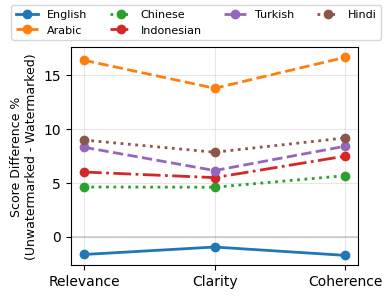

English differences percentage: [2.46623605 3.6598493  3.18257956]
Arabic differences percentage: [ 9.38697318  8.79186603 10.125     ]
Chinese differences percentage: [11.35734072  8.90322581 10.37483266]
Indonesian differences percentage: [12.07883026 12.29508197 14.1025641 ]
Turkish differences percentage: [13.96276596 12.4535316  14.95448635]
Hindi differences percentage: [20.51282051 20.07067138 22.2962963 ]


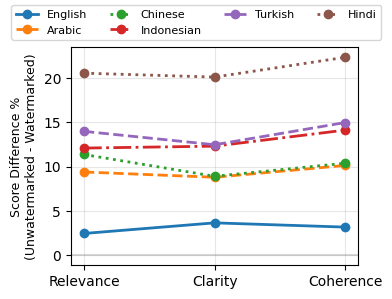

English differences percentage: [20.34753363 17.8440607  22.69087026]
Arabic differences percentage: [37.47126437 33.1524688  38.4057971 ]
Chinese differences percentage: [26.22073579 23.40966921 27.81026641]
Indonesian differences percentage: [30.23399015 27.32018561 33.13397129]
Turkish differences percentage: [31.46496815 28.98550725 33.87197017]
Hindi differences percentage: [38.41155235 37.56906077 39.37232525]


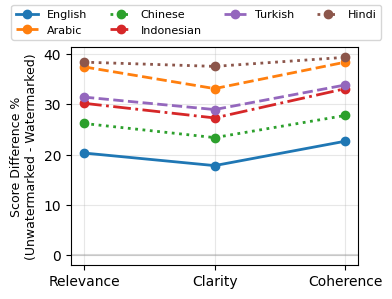

English differences percentage: [19.94366197 17.33403583 21.37445887]
Arabic differences percentage: [29.51219512 26.61996497 30.70489845]
Chinese differences percentage: [27.08058124 24.18952618 28.7627551 ]
Indonesian differences percentage: [36.70886076 34.01592719 39.59064327]
Turkish differences percentage: [47.03000612 42.55691769 48.6260454 ]
Hindi differences percentage: [26.37195122 25.32374101 27.76523702]


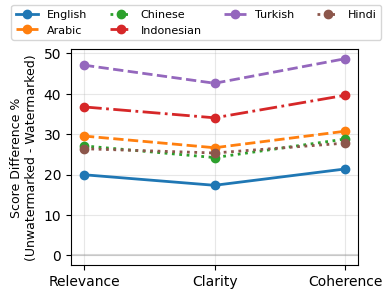

In [12]:
plot_gpt_judge_clarity_coherence(task = 'lfqa', method='KGW', suffix='selected_criteria')
plot_gpt_judge_clarity_coherence(task = 'lfqa', method='Unigram', suffix='selected_criteria')
plot_gpt_judge_clarity_coherence(task = 'lfqa', method='XSIR', suffix='selected_criteria')
plot_gpt_judge_clarity_coherence(task = 'lfqa', method='EXP', suffix='selected_criteria')

# c4
plot_gpt_judge_clarity_coherence(task = 'c4', method='KGW', suffix='selected_criteria')
plot_gpt_judge_clarity_coherence(task = 'c4', method='Unigram', suffix='selected_criteria')
plot_gpt_judge_clarity_coherence(task = 'c4', method='XSIR', suffix='selected_criteria')
plot_gpt_judge_clarity_coherence(task = 'c4', method='EXP', suffix='selected_criteria')

In [ ]:
### add Soft win rates
# soft win rates which equals the number of ties plus
# the number of wins for the watermarked response.
# this could be found in the final_verdict column
def calculate_soft_win_rates(method = 'KGW', language = 'Arabic'):
    
    soft_win_rates = []
    tie_rates = []
    watermarked_rates = []
    
    data = df_dict[method][language]
    for index, row in data.iterrows():
        # print(f"Gamma: {row['gamma']}, Delta: {row['delta']}")
        # print the index
        # print(f"Index: {index}")
        # print("GPT Judge Scores:")
        soft_wins = 0
        ties = 0
        watermarked = 0
        for item in row['final_verdict']:
            # print(item)
            if item == "Tie" or item == "Watermarked":
                soft_wins += 1
            if item == "Tie":
                ties += 1
            if item == "Watermarked":
                watermarked += 1
        # print("\n")
        soft_win_rates.append(soft_wins / len(row['final_verdict']))
        tie_rates.append(ties / len(row['final_verdict']))
        watermarked_rates.append(watermarked / len(row['final_verdict']))
        
        if method == "KGW" or method == "Unigram":
            # print soft win rates with the gamma and delta values
            gamma = row['gamma']
            delta = row['delta']
            # only print for gamma = 0.1 and delta = 2.0
            if gamma == 0.5 and delta == 2.0:
                print(f"Gamma={gamma}, delta={delta}: {watermarked / len(row['final_verdict'])} {ties / len(row['final_verdict'])} {soft_wins / len(row['final_verdict'])}")
        elif method == "XSIR":
            delta = row['delta']
            if delta == 2.0:
                print(f"{method} - Delta={delta}: {watermarked / len(row['final_verdict'])} {ties / len(row['final_verdict'])} {soft_wins / len(row['final_verdict'])}")
        else:
            print(f"{method}: {watermarked / len(row['final_verdict'])} {ties / len(row['final_verdict'])} {soft_wins / len(row['final_verdict'])}")

    return soft_win_rates

In [94]:
for method in all_methods:
    print(f"Method: {method}")
    for language in languages:
        print(f"{language} Soft Win and Tie Rates:")
        soft_win_rates = calculate_soft_win_rates(method=method, language=language)
        print()

Method: KGW
English Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.416 0.054 0.47

Arabic Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.41 0.15 0.56

Chinese Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.31 0.256 0.566

Indonesian Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.286 0.182 0.468

Method: Unigram
English Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.384 0.078 0.462

Arabic Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.37 0.124 0.494

Chinese Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.244 0.266 0.51

Indonesian Soft Win and Tie Rates:
Gamma=0.5, delta=2.0: 0.27 0.142 0.412

Method: XSIR
English Soft Win and Tie Rates:
XSIR - Delta=2.0: 0.198 0.062 0.26

Arabic Soft Win and Tie Rates:
XSIR - Delta=2.0: 0.218 0.124 0.342

Chinese Soft Win and Tie Rates:
XSIR - Delta=2.0: 0.108 0.242 0.35

Indonesian Soft Win and Tie Rates:
XSIR - Delta=2.0: 0.158 0.118 0.276

Method: EXP
English Soft Win and Tie Rates:
EXP: 0.104 0.038 0.142

Arabic Soft Win and Tie Rates:
EXP: